# Unsupervised Clustering Methods for Meteorological European Configurations/ Patterns


<span style="color: red;">- ORA MODIFICO IL MODO DI STANDARDIZZARE -> STANDARDIZZAZIONE GLOBALE così:</span>
- Preservati i rapporti relativi: z_250 resta sempre > z_500 > z_850
- Mantiengo le distanze verticali: spessore della troposfera conservato
- Conservo la stagionalità: inverno vs estate mantengono le differenze assolute
- problemi numerici risolti: tutte le feature hanno scala simile per PCA/clustering

<span style="color: red;">- ds filtrato con z preso a 500 e 850 </span>


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
#import gc
import matplotlib.pyplot as plt
import shapefile as shp
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

#from sklearn.decomposition import IncrementalPCA
import importlib
import utils.data_processing
import utils.visualization
importlib.reload(utils.data_processing)
importlib.reload(utils.visualization)

# Import the functions 
from utils.data_processing import prepare_data_matrix, apply_global_standardization, perform_incremental_pca

from utils.visualization import plot_variance, scatter_plot_2d,scatter_plot_3d,  add_country_boundaries
from utils.visualization import visualization_pca_coefficient

from utils.clusterization import kmeans, elbow_analysis, gap_statistic, silhouette_analysis

## 1 Data Loading and Initial Analysis

The dataset used in this analysis consists of ERA5 reanalysis data downloaded from the Copernicus Climate Data Store (CDS). ERA5 is the fifth generation ECMWF atmospheric reanalysis providing comprehensive meteorological data with high spatial and temporal resolution. The dataset covers a 5-year period from January 1, 2000 to December 31, 2004, focusing on the European region. It includes four key atmospheric variables: geopotential height (z), temperature (t), and horizontal wind components (u, v), measured at three pressure levels (850 hPa, 500 hPa, and 250 hPa) on a regular 0.25° × 0.25° grid. This high-resolution gridded data provides a comprehensive representation of European atmospheric patterns and will be used to identify meteorological configurations through unsupervised clustering methods.

In [2]:
# Load the dataset
ds = xr.open_dataset('era5_ridotto.grib', engine= 'cfgrib') # XArray DataSet
#ds = ds.sel(isobaricInhPa =[500, 850])
print("Overview of the dataset:")
print(f"   • Variables: {list(ds.data_vars.keys())}")
print(f"   • Coordinates: {list(ds.coords.keys())}")

Overview of the dataset:
   • Variables: ['z']
   • Coordinates: ['number', 'time', 'step', 'isobaricInhPa', 'latitude', 'longitude', 'valid_time']


In [3]:
# Dimenision details
print("Dimension details:")
if 'latitude' in ds.dims:
    print(f"   • Latitude: {ds.dims['latitude']} points ({ds.latitude.min().values:.1f}° - {ds.latitude.max().values:.1f}°)")
if 'longitude' in ds.dims:
    print(f"   • Longitude: {ds.dims['longitude']} points ({ds.longitude.min().values:.1f}° - {ds.longitude.max().values:.1f}°)")
if 'time' in ds.dims:
    print(f"   • Time: {ds.dims['time']} steps ({pd.to_datetime(ds.time.values[0]).strftime('%Y-%m-%d')} - {pd.to_datetime(ds.time.values[-1]).strftime('%Y-%m-%d')})")
if 'isobaricInhPa' in ds.dims:
    print(f"   • Pressure levels: {ds.dims['isobaricInhPa']} levels ({list(ds.isobaricInhPa.values)} hPa)")

#Variables 
print("Variables in the dataset:")
for var in ds.data_vars:
    var_data = ds[var]
    print(f"   • {var}: {var_data.dims} - {var_data.attrs.get('long_name', 'N/A')}")
    print(f"     └─ Units: {var_data.attrs.get('units', 'N/A')}")

Dimension details:
   • Latitude: 201 points (20.0° - 70.0°)
   • Longitude: 321 points (-40.0° - 40.0°)
   • Time: 1827 steps (2000-01-01 - 2004-12-31)
   • Pressure levels: 3 levels ([np.float64(850.0), np.float64(500.0), np.float64(250.0)] hPa)
Variables in the dataset:
   • z: ('time', 'isobaricInhPa', 'latitude', 'longitude') - Geopotential
     └─ Units: m**2 s**-2


In [4]:
# Total dimensionality
total_spatial_points = 1
for dim in ['latitude', 'longitude']:
    if dim in ds.dims:
        total_spatial_points *= ds.dims[dim]

total_features = len(ds.data_vars) * ds.dims.get('isobaricInhPa', 1) * total_spatial_points
print("DIMENSIONALITY:")
print(f" • Spatial points: {total_spatial_points}")
print(f" • Total features per timestep: {total_features:,}")
print(f" • Temporal samples: {ds.dims.get('time', 1)}")

DIMENSIONALITY:
 • Spatial points: 64521
 • Total features per timestep: 193,563
 • Temporal samples: 1827


In [5]:
# Missing values check: already verified to be 0
print("MISSING VALUES: No missing values (previously verified)")

MISSING VALUES: No missing values (previously verified)


There are no missing values in the dataset

## 2 Preprocessing and Feature Selection

### 2.1 Preparing Data Matrix

#### Initial data structure

Our dataset consists of geopotential height (z) measurements organized as a 4-dimensional array. The structure of this array is: a temporal dimension of 1827 daily observations from 1.01.2000 to 31.12.2004; a spatial dimension of 64521 points given by 201 latitude values x 321 longitude values and a vertical dimension given by the fact that the measurements are taken at 3 different atmospheric pressure levels ( 850 hPa, 500 hPa, 250 hPa).  
The data are organized in a nested structure where for each pressure level, measurements are recorded at every latitude-longitude grid point across the European region. 

_ _ _ - - _ _ _ (  
**Scatola** = Dataset   
dentro la scatola di sono dei blocchi di fogli  
**Un blocco di fogli** = un signolo giorno ( da 1 gennaio 2000 a 31 dic 2004)  -> <span style="color: red;">1827 giorni</span>  
il blocco di fogli è formato da 1 foglio   
**Un foglio contiene i valori di una variabile** =  variabile: z -> <span style="color: red;">1 variabile</span>  

Ogni foglio contiene i valori di quella variabile presi in ogni singolo punto dello 'spazio' definito dalla longitudine e dalla laitudine. Quindi in ogni foglio c'è il valore di quella variabile in ognuno dei 201(lat) × 321(lon). Una specie di tabella.  -> <span style="color: red;">64521 punti spaziali</span>

**Solo che questa tabella di valori è presa per ognuno dei 3 livelli di pressione** = 850 hPa, 500 hPa, 250 hPa -> <span style="color: red;">3 lv di pressione</span>

**TOT= 193,563 valori per blocco**   x 1827 giorni

Per la variabile z: 
__per ogni livello di pressione:  
____per ogni lat:  
______per ogni lon:  
________prendi il valore  

Se penso al foglio come una tabella con 193,563 colonne, e solo 1 riga, che rappresenta tutte le misure spaziali per quel giorno, posso mettere insieme tutti i 1827 fogli, e ottenere una matrice finale di forma (1827, 193,563). Ogni riga è un giorno. Ogni colonna è una variabile a una certa posizione e pressione.  
_ _ _ - - _ _ _ )


#### Final data structure

For our following analysis we need to reshape this multimensional matrix into a 2D matrix. The temporal dimension will remain the same, each column, instead, will become a combination of the geopotential height at a specific spatial location (latitude-longitude pair) and pressure level.

           feature_1  feature_2  ...  feature_193,563 
time_1 →      ...        ...             ...  
time_2 →      ...        ...             ...  
  ⋮                             
time_1827 →   ...        ...             ...  


In [6]:
print("PREPARING DATA MATRIX")
X, data_matrices = prepare_data_matrix(ds)
print(f"Data Matrix: {X.shape} (samples, features)")

PREPARING DATA MATRIX
   • Processing z...
Data Matrix: (1827, 193563) (samples, features)
Data Matrix: (1827, 193563) (samples, features)


### 2.2 Standardization

For the standardization process, we initially implemented a per-feature standardization approach, where each spatial point was normalized with respect to its local temporal variability. However, this approach presents a significant limitation: all physical relationships between pressure levels (z₂₅₀ > z₅₀₀ > z₈₅₀) are lost, and the vertical structure of the troposphere becomes distorted.

To address this issue, we adopted a global standardization approach. This method preserves the relative relationships between pressure levels and maintains the atmospheric depth structure. Additionally, it ensures that all features have comparable scales, which is essential for subsequent analyses such as PCA and clustering, while retaining the meteorological interpretability of the data.

In [7]:
print("GLOBAL STANDARDIZATION")

# Applica standardizzazione globale usando la funzione da utils
X, global_mean, global_std = apply_global_standardization(X)

print("Before standardization:")
print(f"Global mean: {global_mean:.2f}m")
print(f"Global std: {global_std:.2f}m")
print(f"Dataset shape: {X.shape}")

print("After standardization:")
print(f" • New global mean: {X.mean():.6f}")
print(f" • New global std: {X.std():.6f}")

# Verify some sample statistics
print(f" • Sample min: {X.min():.3f}")
print(f" • Sample max: {X.max():.3f}")

GLOBAL STANDARDIZATION
Before standardization:
Global mean: 57405.69m
Global std: 36090.11m
Dataset shape: (1827, 193563)
After standardization:
 • New global mean: 0.000007
Before standardization:
Global mean: 57405.69m
Global std: 36090.11m
Dataset shape: (1827, 193563)
After standardization:
 • New global mean: 0.000007
 • New global std: 0.999999
 • Sample min: -1.383
 • Sample max: 1.424
 • New global std: 0.999999
 • Sample min: -1.383
 • Sample max: 1.424


Now, an esample of standardization for 3 points is shown.

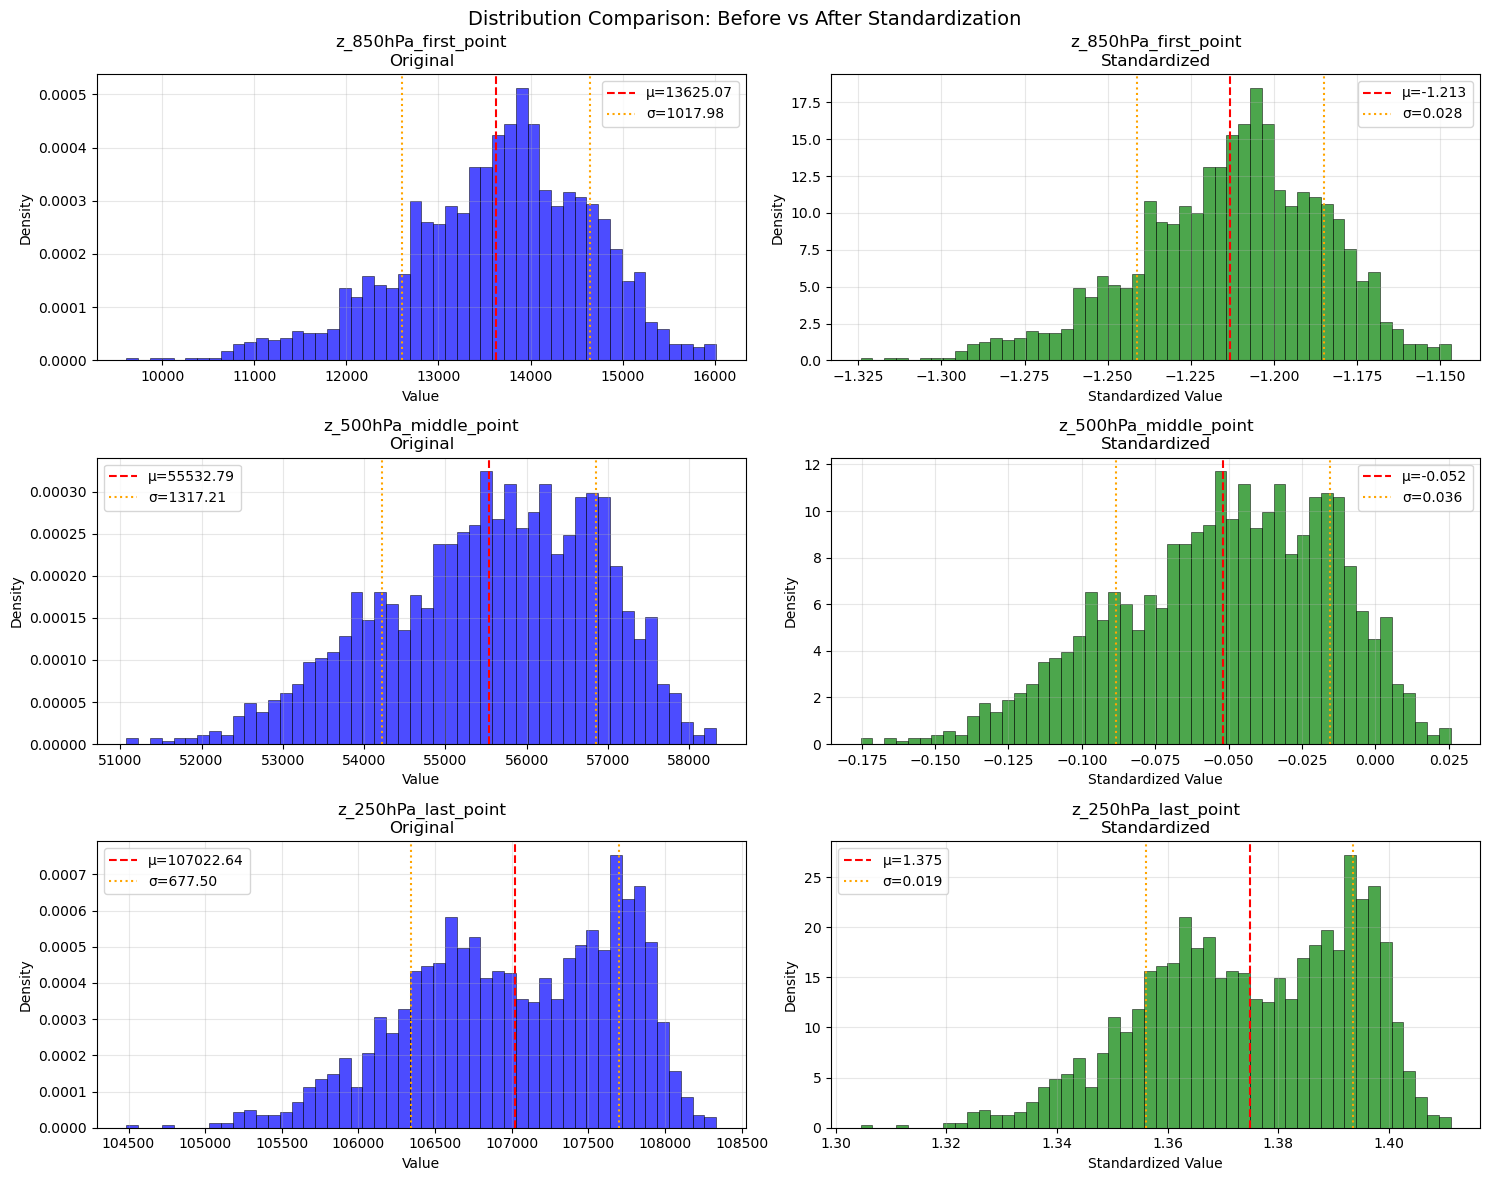

### 2.3 Principal Component Analysis

For the Principal Component Analysis, we implemented an incremental PCA approach to avoid potential memory and numerical issues when dealing with large datasets. The incremental PCA processes data in batches while maintaining mathematical equivalence to standard PCA, ensuring convergence to identical results.

The primary objective of PCA is to represent the dataset in a lower-dimensional space using a reduced number of variables (principal components) while preserving as much variance (information) as possible from the original data. This dimensionality reduction technique enables us to capture the most significant patterns of atmospheric variability while reducing computational complexity for subsequent clustering analysis.



**Varianza = quanto i dati si "spargono" attorno alla media**
- La PCA cerca le **direzioni di MASSIMA varianza**   
- Trova i pattern meteorologici che cambiano di più nel tempo  
- Cattura le configurazioni atmosferiche principali (NAO, anticicloni, ecc.)  

<span style="color: orange;"> La PCA non assegna etichette o categorie: ogni campione rimane un punto nello spazio, solo rappresentato in modo più efficiente. Le componenti non sono cluster, ma assi cartesiani scelti in modo che la varianza sia massima lungo il primo asse, poi il secondo ecc. Quindi la PCA non è un clustering, anche se può rivelare struttura nei dati.

Principal components are a sequence of projections of the data, mutually uncorrelated and ordered in variance.   
The principal components of a set of data in IRp provide a sequence of best
linear approximations to that data, of all ranks q ≤ p.  
(BookAdvanced, pg 553)

In [8]:
print("INCREMENTAL PCA ANALYSIS")

n_components = 20  # Reduced to 20 components for safety with batch processing
batch_size = 100    # Increased batch size to accommodate more components

print(f"   • Target components: {n_components}")
print(f"   • Batch size: {batch_size}")
print(f"   • Data shape: {X.shape}")
 
X_pca, ipca, explained_variance_ratio, cumulative_variance = perform_incremental_pca(X, n_components=n_components, batch_size=batch_size)

INCREMENTAL PCA ANALYSIS
   • Target components: 20
   • Batch size: 100
   • Data shape: (1827, 193563)
   • Target components: 20
   • Batch size: 100
   • Data shape: (1827, 193563)
   • Original shape: (1827, 193563)
   • PCA shape: (1827, 20)

   • VARIANCE ANALYSIS:
   • Total explained variance (20 components): 0.961
   • 80.0% variance: 5 components
   • 85.0% variance: 6 components
   • 90.0% variance: 9 components
   • 95.0% variance: 17 components

   • First 10 components variance: [0.54175201 0.09899303 0.08342759 0.06019305 0.04485104 0.0279965
 0.01897723 0.01710401 0.01276212 0.00935634]
   • First 20 components cumulative: 0.961
   • Original shape: (1827, 193563)
   • PCA shape: (1827, 20)

   • VARIANCE ANALYSIS:
   • Total explained variance (20 components): 0.961
   • 80.0% variance: 5 components
   • 85.0% variance: 6 components
   • 90.0% variance: 9 components
   • 95.0% variance: 17 components

   • First 10 components variance: [0.54175201 0.09899303 0.0834275

Il grafico mostra chiaramente un forte “elbow” nei primi componenti: la prima componente da sola spiega il 54.2% (!), la seconda il 9.9%, e poi via via la varianza scende rapidamente → significa che gran parte dell’informazione è concentrata nei primi componenti

VARIANCE VISUALIZATION


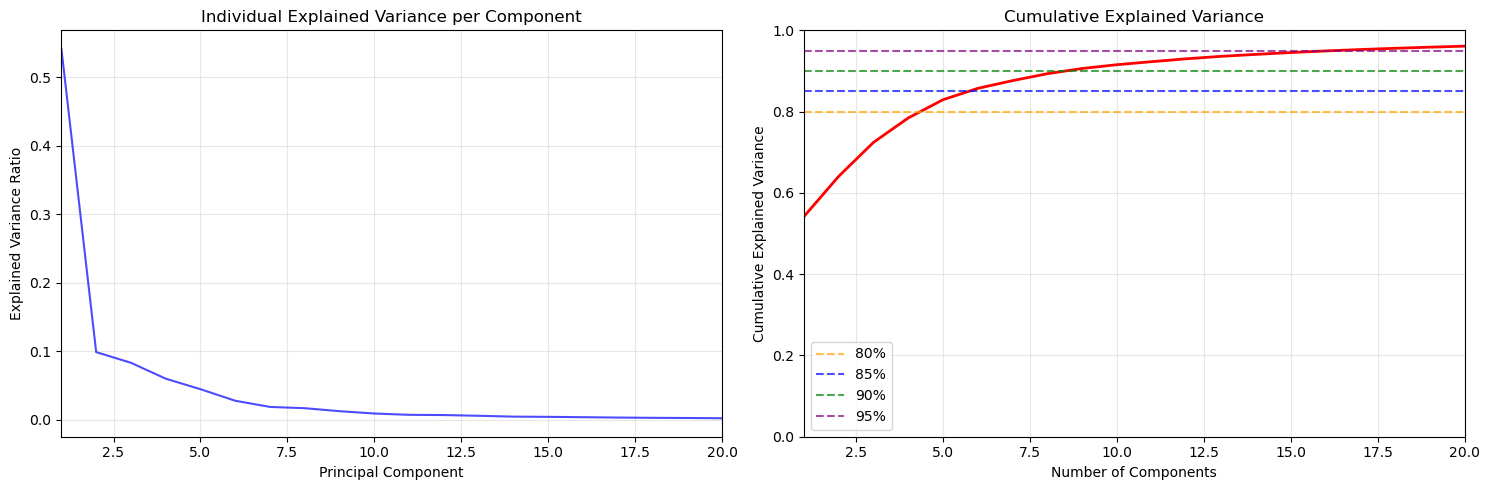

In [9]:
# Visualization of explained variance
print("VARIANCE VISUALIZATION")

# Create plots for variance analysis

plot_variance(explained_variance_ratio, cumulative_variance, n_components)


grafico a sinistra: varianza spiegata per singola componente
(di solito decresce velocemente, “elbow” shape)  
mostra la varianza spiegata da ciascun componente  
conferma che la prima componente è molto informativa  
curva a gomito → tipico nei dati ridondanti

grafico a destra: varianza spiegata cumulata
(sale a gradini, fino a saturare verso 1)  
mostra la varianza cumulata
le linee orizzontali (80%, 90%, 95%)   
la curva rossa sale rapidamente ma si stabilizza, quindi i componenti successivi hanno impatto minore

<span style="color: orange;">la PCA permette di proiettare i dati in un nuovo spazio ridotto che mantiene la maggior parte dell’informazione
Inoltre, facilita interpretazioni fisiche (ad esempio i primi componenti possono corrispondere a pattern meteorologici dominanti) e riduce il rumore e la ridondanza tra variabili. Sceòlgo 20 compon. princ. perchè comunque arrivo al 97.5% di varianza spiegata che è molto buono ed eveito di prendere più componenti principali perchè così non introduco rumore that can affect the clusterization.</span>

In [10]:
n_components_final = 20  # Final number of components based on variance analysis
print(f"   • Original data shape: {X.shape}")
print(f"   • PCA full shape: {X_pca.shape}")
 
variance_explained = cumulative_variance[n_components_final-1]
print(f"   • Actual variance explained: {variance_explained:.3f} ({variance_explained*100:.1f}%)")


   • Original data shape: (1827, 193563)
   • PCA full shape: (1827, 20)
   • Actual variance explained: 0.961 (96.1%)


#### 2.3.1 Visualization of the first components

I plots 2D/3D servono per:

- PC1 vs PC2: scatter plot per vedere se ci sono cluster naturali
- PC1 vs PC2 vs PC3: scatter 3D per pattern più complessi
- Istogrammi delle prime 4-5 componenti  
Se vedo "nuvole" separate → suggerisce struttura a cluster

VISUALIZATION OF PRINCIPAL COMPONENTS


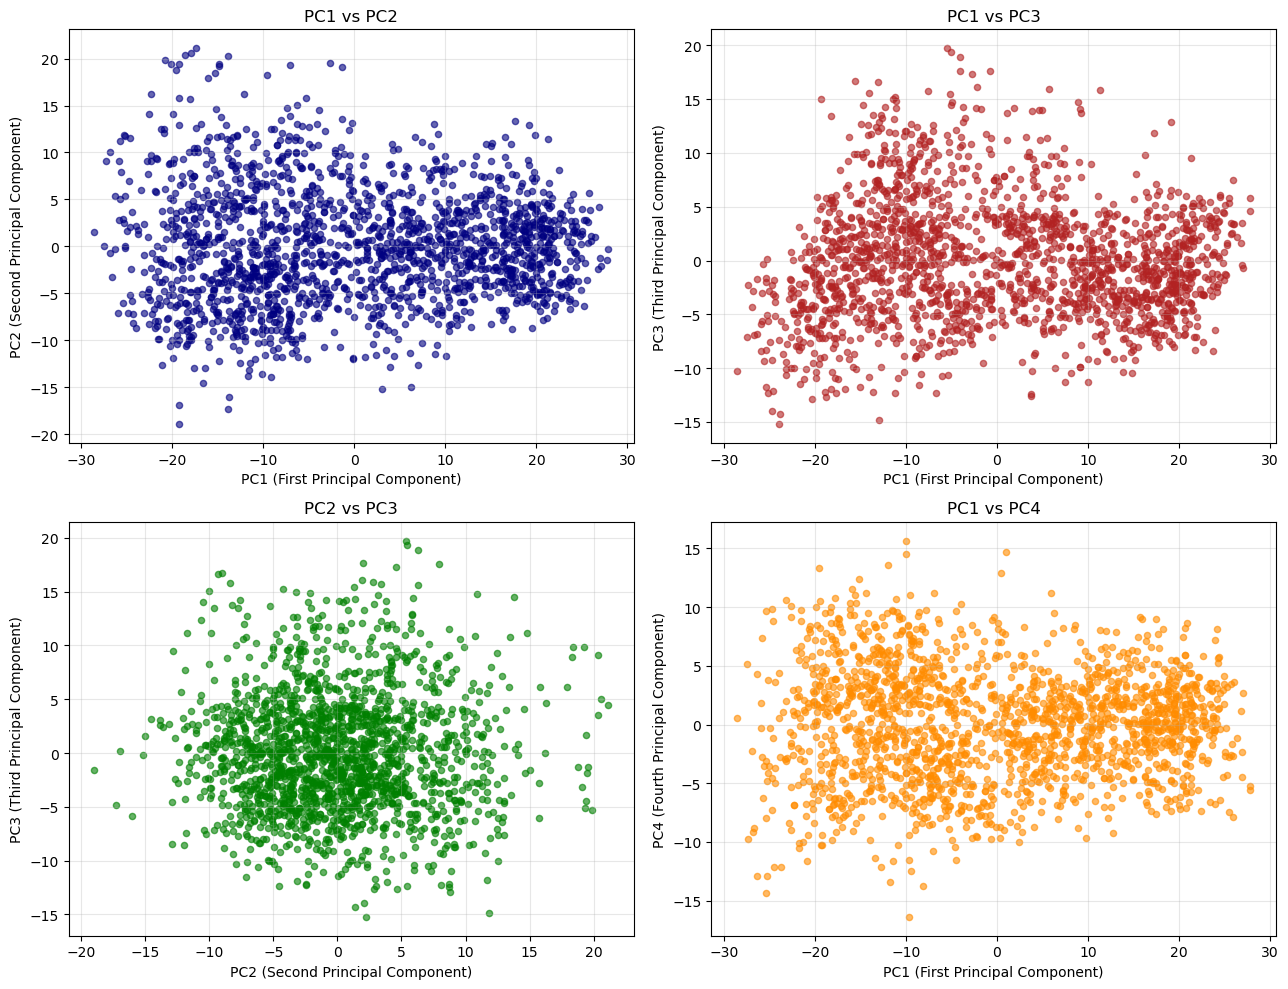

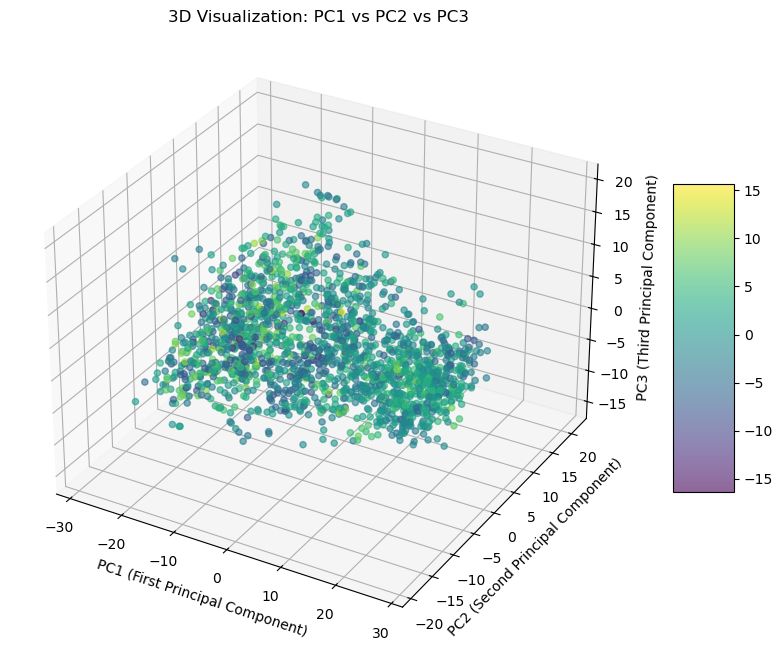

In [11]:
print("VISUALIZATION OF PRINCIPAL COMPONENTS")

# 1. SCATTER PLOT 2D: PC1 vs PC2
scatter_plot_2d(X_pca)

# 2. SCATTER PLOT 3D: PC1 vs PC2 vs PC3
scatter_plot_3d(X_pca)


<span style="color: skyblue;">Capire cosa rappresentano i puntini</span> --> La posizione del puntino è determinata dalle sue coordinate proiettate su due componenti principali.

**PC1 vs PC2**: Two distinct clusters are clearly visible, indicating good separation between different meteorological configurations. PC1 appears to capture a primary discriminant direction that effectively separates the data into distinct atmospheric patterns. This suggests that PC1 represents the most significant mode of variability in European weather patterns, potentially corresponding to major synoptic-scale phenomena.

**PC2 vs PC3 and PC1 vs PC3**: The separation between clusters is less pronounced in these projections. PC3 captures more dispersed variance, suggesting it represents secondary meteorological patterns that are more spatially or temporally distributed. The weaker clustering indicates that PC3 may correspond to regional-scale variations or transitional weather states.

**PC1 vs PC4**: PC4 shows minimal evident structure and appears to contain less discriminative information. This component likely represents either background noise or minor meteorological variations that contribute less to the overall atmospheric configuration patterns.


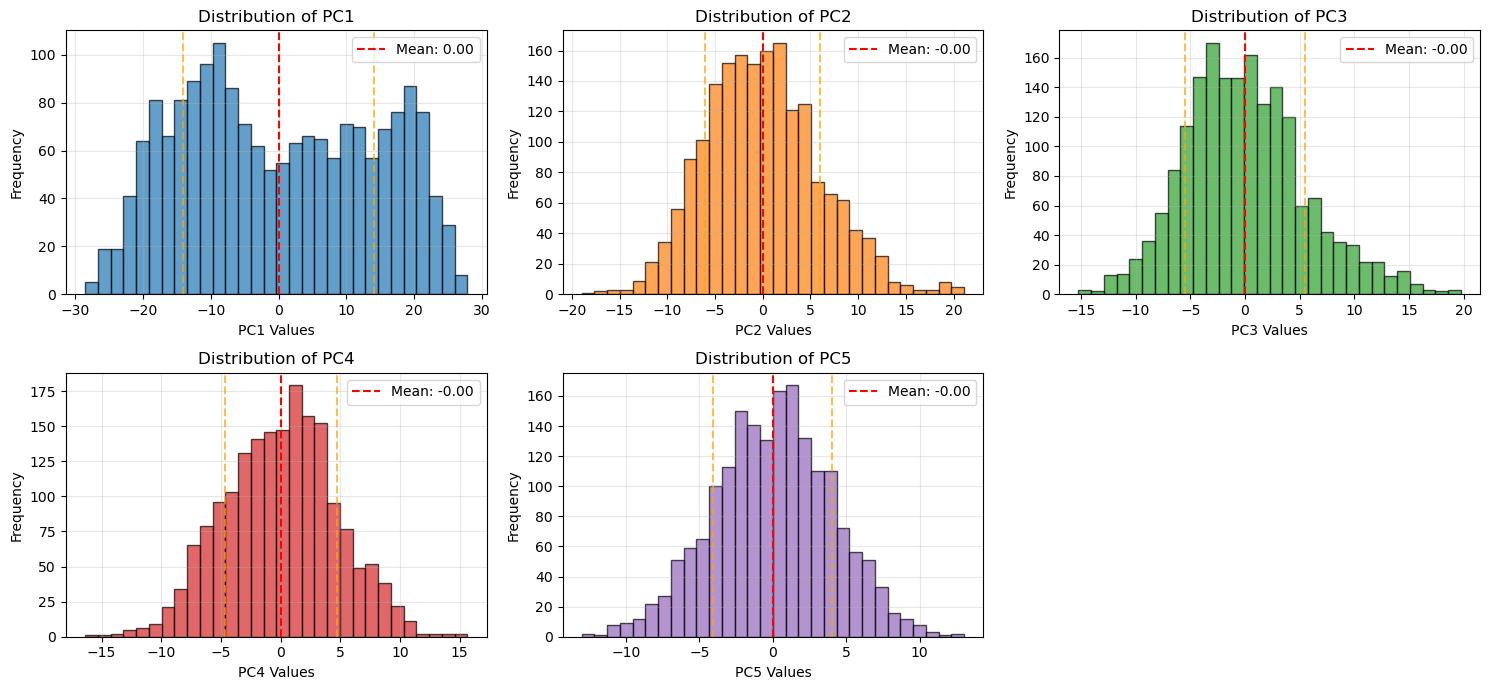


   • SUMMARY STATISTICS FOR FIRST 5 COMPONENTS:
   • PC1: Mean=0.000, Std=14.086, Min=-28.558, Max=27.864
   • PC2: Mean=-0.000, Std=6.021, Min=-18.971, Max=21.116
   • PC3: Mean=-0.000, Std=5.528, Min=-15.231, Max=19.737
   • PC4: Mean=-0.000, Std=4.695, Min=-16.390, Max=15.662
   • PC5: Mean=-0.000, Std=4.053, Min=-13.009, Max=13.021


In [12]:
# 3. HISTOGRAMS of first 5 components
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

for i in range(5):
    axes[i].hist(X_pca[:, i], bins=30, alpha=0.7, color=f'C{i}', edgecolor='black')
    axes[i].set_xlabel(f'PC{i+1} Values')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of PC{i+1}')
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = X_pca[:, i].mean()
    std_val = X_pca[:, i].std()
    axes[i].axvline(mean_val, color='red', linestyle='--', 
                   label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(mean_val + std_val, color='orange', linestyle='--', alpha=0.7)
    axes[i].axvline(mean_val - std_val, color='orange', linestyle='--', alpha=0.7)
    axes[i].legend()

axes[5].remove()

plt.tight_layout()
plt.show()

# 4. SUMMARY STATISTICS
print("\n   • SUMMARY STATISTICS FOR FIRST 5 COMPONENTS:")
for i in range(5):
    pc_data = X_pca[:, i]
    print(f"   • PC{i+1}: Mean={pc_data.mean():.3f}, Std={pc_data.std():.3f}, "
          f"Min={pc_data.min():.3f}, Max={pc_data.max():.3f}")


**PC2, PC3, PC4, PC5** → Normal distributions centered at 0, as expected in normalized PCA. These components show typical Gaussian-like behavior with:
- Mean ≈ 0 
- Symmetric, bell-shaped distributions
- Standard deviations around 1, indicating proper normalization

**PC1** → **Bimodal distribution**   
The bimodal pattern indicates that PC1 effectively separates the data into **two distinct groups**. This suggests:
- Two dominant meteorological regimes in European weather patterns
- PC1 captures the primary mode of atmospheric variability that distinguishes between these regimes
- Strong evidence for natural clustering structure in the data

In [13]:
sf = shp.Reader("world/world-administrative-boundaries.shp")

VISUALIZZAZIONE DELLA PRIME COMPONENTI PRINCIPALI


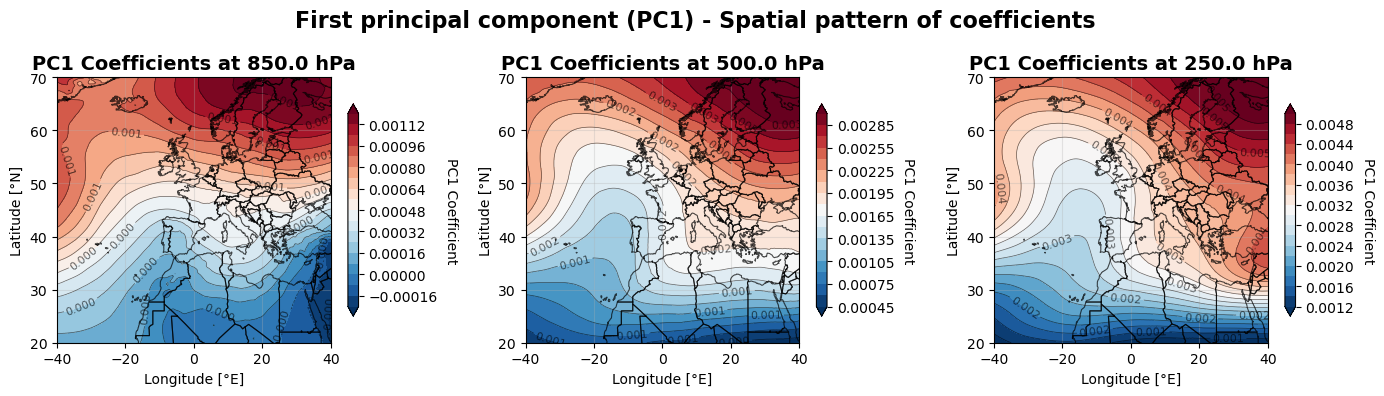

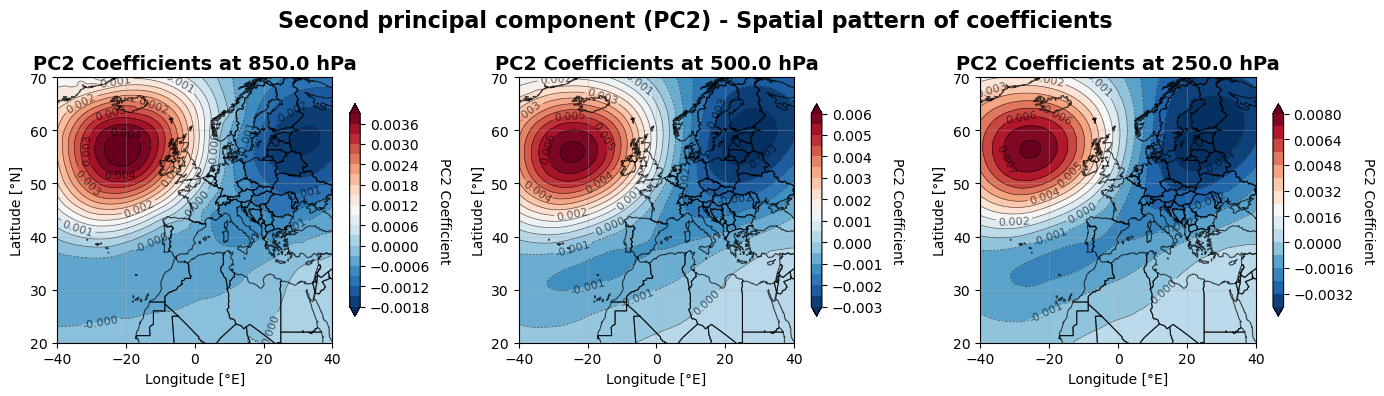

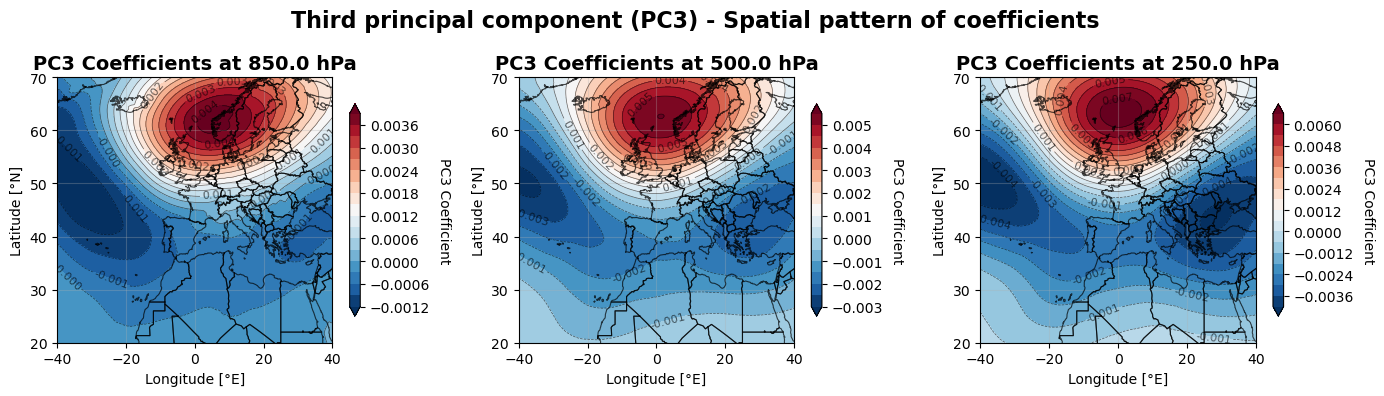

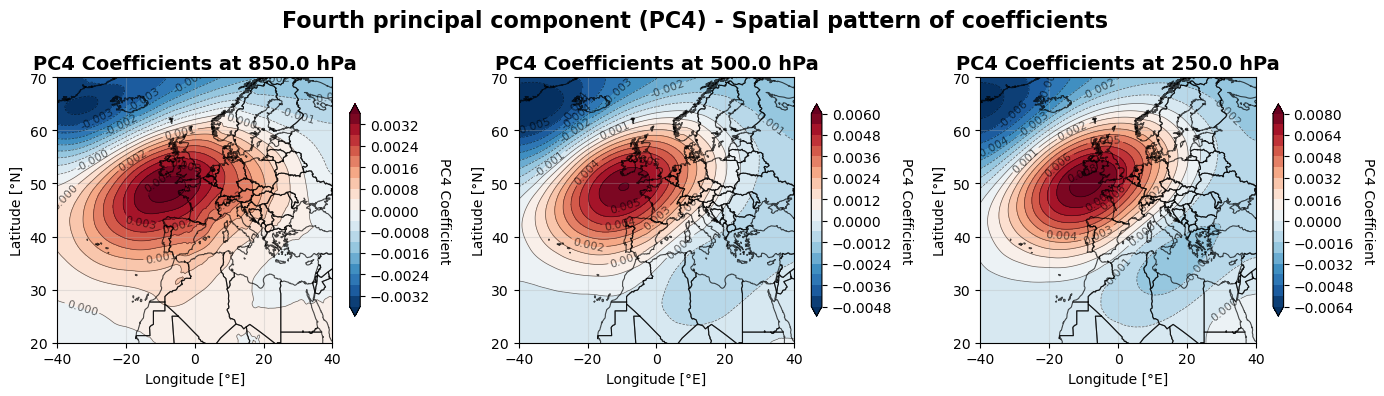

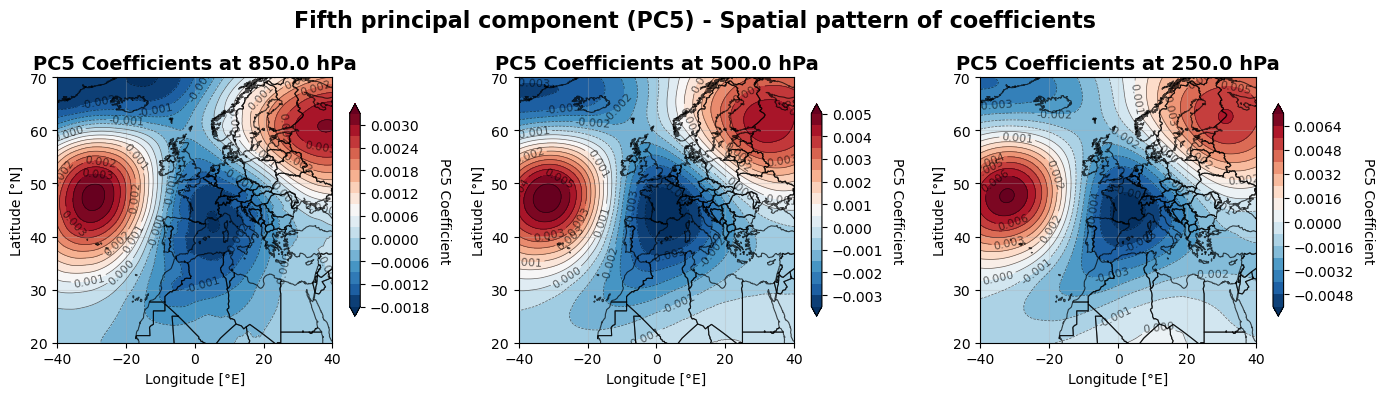


   • STATISTICHE COMPARATIVE PER LIVELLO DI PRESSIONE:
   • Pressure   PC1 Min      PC1 Max      PC2 Min      PC2 Max      PC3 Min      PC3 Max     
   • ------------------------------------------------------------------------------------
   • 850.0      -0.000273    0.001246     -0.001860    0.004137     -0.001457    0.004019    
   • 500.0      0.000369     0.003115     -0.003314    0.006163     -0.003116    0.005506    
   • 250.0      0.001035     0.005185     -0.004709    0.008149     -0.004698    0.006931    


In [14]:
print("VISUALIZZAZIONE DELLA PRIME COMPONENTI PRINCIPALI")

components_to_plot = [
    (ipca.components_[0], "PC1", "First principal component (PC1)"),
    (ipca.components_[1], "PC2", "Second principal component (PC2)"),
    (ipca.components_[2], "PC3", "Third principal component (PC3)"),
    (ipca.components_[3], "PC4", "Fourth principal component (PC4)"),
    (ipca.components_[4], "PC5", "Fifth principal component (PC5)")
]

# Get dimensions from original dataset (ds), not from X_pca which is a numpy array
n_lat = ds.dims['latitude'] if 'latitude' in ds.dims else len(ds.latitude)
n_lon = ds.dims['longitude'] if 'longitude' in ds.dims else len(ds.longitude)
n_pressure = ds.dims['isobaricInhPa'] if 'isobaricInhPa' in ds.dims else len(ds.isobaricInhPa)

lats = ds.latitude.values
lons = ds.longitude.values
pressure_levels = ds.isobaricInhPa.values.tolist()


visualization_pca_coefficient(components_to_plot, pressure_levels, lats, lons, n_pressure, n_lat, n_lon, sf=sf)

# Statistiche comparative per tutte le componenti
print(f"\n   • STATISTICHE COMPARATIVE PER LIVELLO DI PRESSIONE:")
print(f"   • {'Pressure':<10} {'PC1 Min':<12} {'PC1 Max':<12} {'PC2 Min':<12} {'PC2 Max':<12} {'PC3 Min':<12} {'PC3 Max':<12}")
print(f"   • {'-'*84}")

# Ricostruisci tutte le componenti per le statistiche
pc1_reshaped = components_to_plot[0][0].reshape(n_pressure, n_lat, n_lon)
pc2_reshaped = components_to_plot[1][0].reshape(n_pressure, n_lat, n_lon)
pc3_reshaped = components_to_plot[2][0].reshape(n_pressure, n_lat, n_lon)

for i, pressure in enumerate(pressure_levels):
    pc1_level = pc1_reshaped[i, :, :]
    pc2_level = pc2_reshaped[i, :, :]
    pc3_level = pc3_reshaped[i, :, :]
    
    print(f"   • {pressure:<10} {pc1_level.min():<12.6f} {pc1_level.max():<12.6f} "
          f"{pc2_level.min():<12.6f} {pc2_level.max():<12.6f} "
          f"{pc3_level.min():<12.6f} {pc3_level.max():<12.6f}")

The previous plots show the spatial distribution of the PCA coefficients (the values in the array ipca.components_). These coefficients are abstract and cannot be interpreted physically; they represent the mathematical “weight” that each geographical point has in the principal component. Red indicates a positive coefficient, while blue indicates a negative one. The color intensity reflects how strongly that point contributes to the principal component. In other words, the plots highlight where the component is geographically “more active.”

To understand what each principal component actually represents, we then plot the real atmospheric pattern associated with each principal component.

ricostruire il pattern meteorologico fisico che ogni componente principale rappresenta.


=== First principal component (PC1) ===
Range physic pattern PC1: [-138.8, 2636.8]m
Scala comune per PC1: [-2637, 2637]m


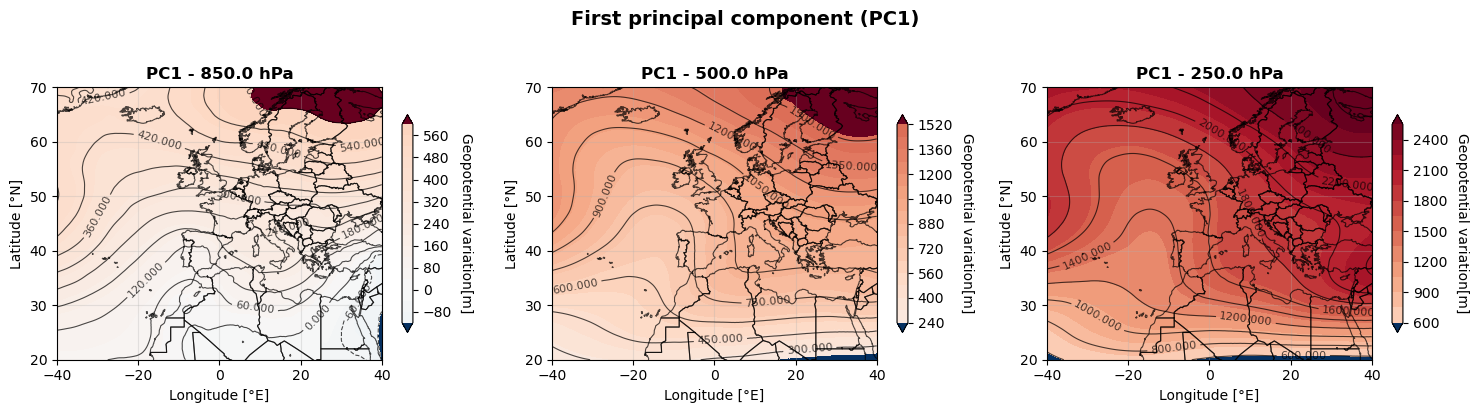

 PC1 statistics:
  850.0 hPa: range [-138.810033, 633.431933]
  500.0 hPa: range [187.622412, 1583.904167]
  250.0 hPa: range [526.525939, 2636.784345]

=== Second principal component (PC2) ===
Range physic pattern PC2: [-1023.5, 1771.3]m
Scala comune per PC2: [-1771, 1771]m


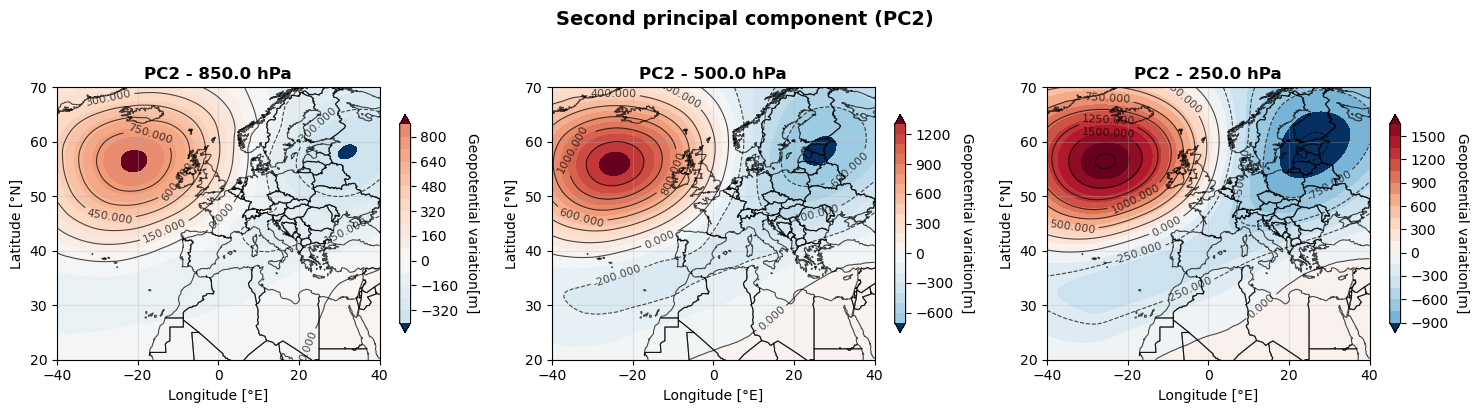

 PC2 statistics:
  850.0 hPa: range [-404.245648, 899.319891]
  500.0 hPa: range [-720.437668, 1339.705835]
  250.0 hPa: range [-1023.508054, 1771.309656]

=== Third principal component (PC3) ===
Range physic pattern PC3: [-937.5, 1383.2]m
Scala comune per PC3: [-1383, 1383]m


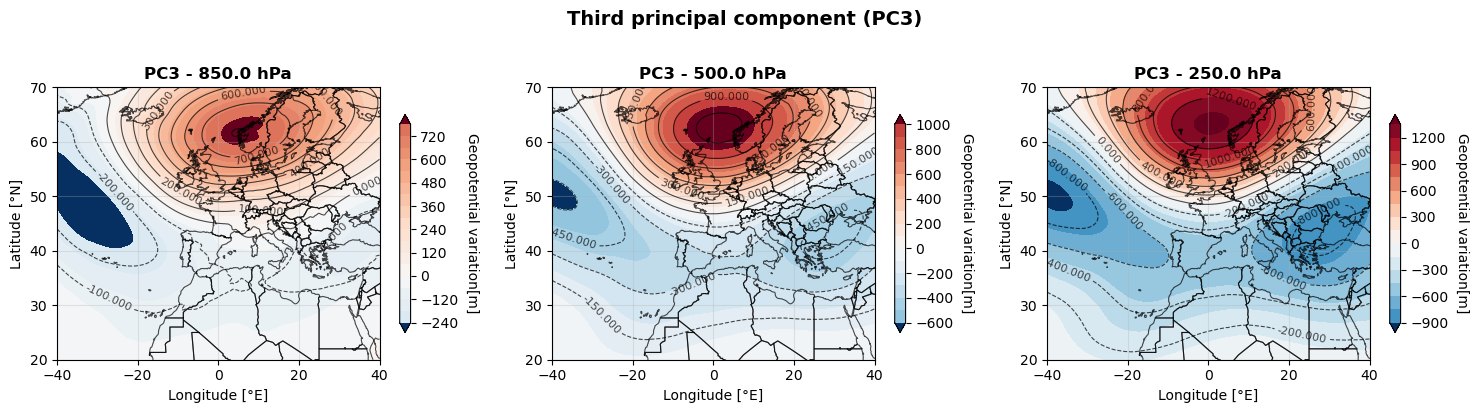

 PC3 statistics:
  850.0 hPa: range [-290.775468, 802.057849]
  500.0 hPa: range [-621.869381, 1098.793230]
  250.0 hPa: range [-937.468762, 1383.153515]

=== Fourth principal component (PC4) ===
Range physic pattern PC4: [-1137.6, 1421.3]m
Scala comune per PC4: [-1421, 1421]m


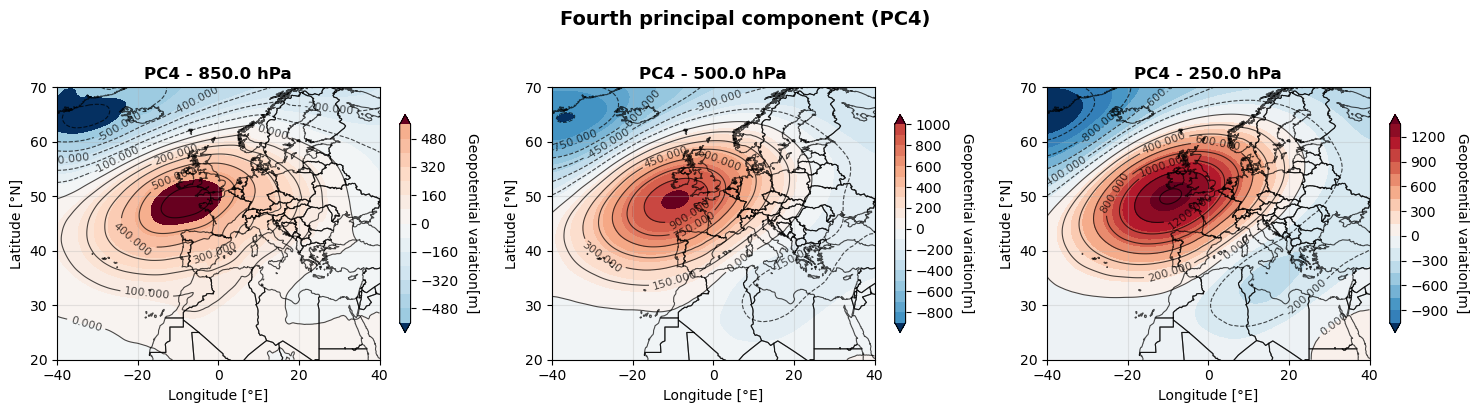

 PC4 statistics:
  850.0 hPa: range [-628.956120, 639.939619]
  500.0 hPa: range [-905.335080, 1020.801137]
  250.0 hPa: range [-1137.620465, 1421.305635]

=== Fifth principal component (PC5) ===
Range physic pattern PC5: [-883.4, 1069.9]m
Scala comune per PC5: [-1070, 1070]m


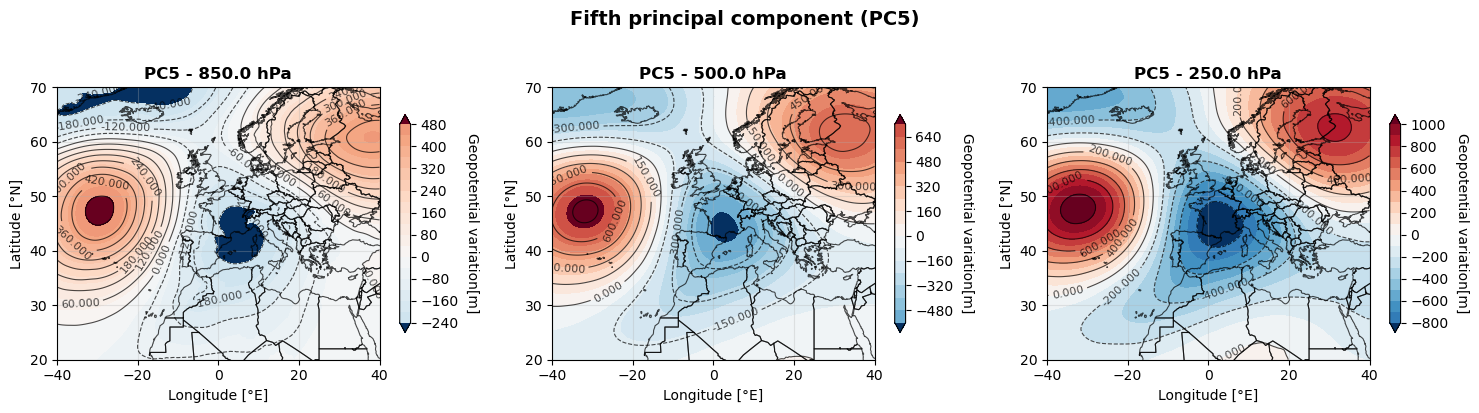

 PC5 statistics:
  850.0 hPa: range [-273.113958, 503.242093]
  500.0 hPa: range [-584.691888, 780.659183]
  250.0 hPa: range [-883.433786, 1069.942344]


In [15]:
### vediamo se funziona
def visualization_pca_real_values(components_to_plot, pressure_levels, lats, lons, n_pressure, n_lat, n_lon, sf=None):
    """
    Visualizza i pattern base delle componenti principali (senza variazioni ±σ)
    """
    
    for pc_idx, (pc_coefficients, pc_name, pc_title) in enumerate(components_to_plot):
        
        print(f"\n=== {pc_title} ===")
        
        # Pattern base = solo i coefficienti della PC (normalizzati)
        # Opzione 1: Coefficienti puri (più interpretabile)
        # pattern_base = pc_coefficients

        # Real Pattern
        pc_std = np.sqrt(ipca.explained_variance_[pc_idx])
        physical_pattern = pc_coefficients * pc_std * global_std

        print(f"Range physic pattern {pc_name}: [{physical_pattern.min():.1f}, {physical_pattern.max():.1f}]m")

        # Reshape per la visualizzazione spaziale
        pattern_reshaped = physical_pattern.reshape(n_pressure, n_lat, n_lon)

        # Valori min/max su TUTTI i livelli di pressione
        global_min = pattern_reshaped.min()
        global_max = pattern_reshaped.max()
        vmax = max(abs(global_min), abs(global_max))
        vmin = -vmax
        print(f"Scala comune per {pc_name}: [{vmin:.0f}, {vmax:.0f}]m")
        
        # Plot semplificato: solo i pattern base
        fig, axes = plt.subplots(1, len(pressure_levels), figsize=(5*len(pressure_levels), 4))
        if len(pressure_levels) == 1:
            axes = [axes]
        
        for i, pressure in enumerate(pressure_levels):
            ax = axes[i]
            data = pattern_reshaped[i, :, :]
            
            lon_grid, lat_grid = np.meshgrid(lons, lats)

            #cmap = "RdBu_r"

            #if pressure >= 700:  # Bassa pressione (850 hPa) 
            #    pressure_label = "Bassa Pressione"
            #else:  # Alta pressione (500 hPa) 
            #    pressure_label = "Alta Pressione"


            # Contour lines
            contour_lines = ax.contour(lon_grid, lat_grid, data, 
                                      levels=12, linewidths=0.8, colors='black', alpha=0.7)
            
            # Contour filled (colori)
            contour_filled = ax.contourf(lon_grid, lat_grid, data, 
                                        levels=20, cmap="RdBu_r", vmin=vmin, vmax=vmax, extend='both')
            
            # Labels su contour lines
            ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.3f')
            
            # Confini europei
            if sf is not None:
                add_country_boundaries(ax, sf)
            
            ax.set_title(f'{pc_name} - {pressure} hPa', 
                        fontsize=12, fontweight='bold')
            ax.set_xlabel('Longitude [°E]')
            ax.set_ylabel('Latitude [°N]')
            ax.set_xlim([lons.min(), lons.max()])
            ax.set_ylim([lats.min(), lats.max()])
            ax.grid(True, alpha=0.3)
            
            cbar = plt.colorbar(contour_filled, ax=ax, shrink=0.8)
            cbar.set_label('Geopotential variation[m]', rotation=270, labelpad=15)
        
        # Title generale
        fig.suptitle(f'{pc_title}', 
                     fontsize=14, fontweight='bold', y=1.02)
        
        plt.tight_layout()
        plt.show()
        
        # Statistiche sui pattern
        print(f" {pc_name} statistics:")
        for i, pressure in enumerate(pressure_levels):
            pattern_level = pattern_reshaped[i, :, :]
            print(f"  {pressure} hPa: range [{pattern_level.min():.6f}, {pattern_level.max():.6f}]")

# Uso della nuova funzione
visualization_pca_real_values(components_to_plot, pressure_levels, lats, lons, 
                       n_pressure, n_lat, n_lon, sf=sf)

Mostra le vere variazioni fisiche in metri di geopotenziale  
Risultato del calcolo: coefficienti × deviazione_standard × scala_globale  
Rappresenta quanto cambia realmente il geopotenziale quando quella PC varia di ±1σ  
Mostra quanto si alzano/abbassano i livelli di pressione  
Rappresenta i pattern atmosferici reali che quella PC cattura   
- Variazioni reali: "quando PC1 aumenta di 1σ, il geopotenziale aumenta di X metri qui"
- Intensità meteorologica: quanto sono forti i cambiamenti di pressione  
_ _ _ - - _ _ _ 

**Prima Componente Principale (PC1)**  
Pattern identificato: GRADIENTE NORD-SUD EUROPEO

PC1 Positivo (MAX): Configurazione con alta pressione al sud e bassa al nord

Anticiclone prominente sull'Europa meridionale/Mediterraneo  
Depressione ciclonica sulla Scandinavia  
Forte gradiente barico nord-sud (differenza di 1214m a 850 hPa)  
PC1 Negativo (MIN): Configurazione opposta

Alta pressione estesa verso nord  
Pattern più omogeneo su tutta l'Europa  
Rappresenta condizioni più stabili e uniformi

**Seconda Componente Principale (PC2)**  
Pattern identificato: GRADIENTE OVEST-EST

PC2 Positivo (MAX): Alta pressione a ovest, bassa a est

Anticiclone atlantico che si estende verso l'Europa occidentale  
Valori di geopotenziale più bassi verso est  
Pattern tipico dell'influenza atlantica  
PC2 Negativo (MIN): Inversione del gradiente ovest-est

Configurazione con influenza continentale più marcata  
Differenze minori tra livelli (solo 345m a 500 hPa)  

**Terza Componente Principale (PC3)**  
Pattern identificato: PATTERN DIPOLARI COMPLESSI    

PC3 Positivo (MAX): Strutture dipolari ben definite

Alternanza di centri di alta e bassa pressione  
Pattern più localizzati e complessi  
PC3 Negativo (MIN): Configurazioni più zonali  

Pattern più estesi longitudinalmente  
Strutture meno localizzate  
🔍 OSSERVAZIONI CHIAVE  
Coerenza Verticale: I pattern sono coerenti attraverso tutti i livelli atmosferici (850, 500, 250 hPa),   indicando strutture barotropiche profonde

Intensità del Segnale: PC1 mostra le differenze più marcate (6353m a 250 hPa), confermando che è il modo dominante di variabilità

Significato Meteorologico:

PC1 rappresenta l'oscillazione principale dell'Europa tra configurazioni meridionali e settentrionali  
PC2 cattura l'influenza atlantica vs continentale  
PC3 descrive pattern più complessi e localizzati

_ _ _ - - _ _ _ - - _ _ _ 

We chose **not to weight the principal components** by their explained variance for the clustering analysis. While PC1 dominates with 54.2% of the variance compared to PC2 (9.9%) and PC3 (8.3%), weighting schemes significantly compromise the clustering quality. Linear weighting causes PC1 to dominate 97.5% of the clustering influence, effectively reducing the problem to a unidimensional analysis and eliminating the contribution of meteorologically meaningful secondary patterns.   
Even moderate $\sqrt{variance}$ weighting biases the clustering toward PC1 (84% influence) while drastically reducing the impact of PC2 and PC3. In contrast, unweighted components maintain a balanced contribution, preserving the multidimensional structure of atmospheric variability.   
This approach is particularly important for meteorological applications where secondary components often capture crucial regional patterns, seasonal variations, or synoptic-scale features that, despite explaining less variance globally, are essential for identifying distinct weather regimes. 

## 3 Clusterization


Now that we have analyzed the data, we have performed Principal Component Analysis (PCA) in order to reduce the dimensionality of the dataset and to highlight the most relevant features and components.
The next step is to implement an algorithm to cluster the data. The first method we will apply is the k-means algorithm.

_pg 28 articolo 2-the classification of atmosphere .._

### 3.1 K-means Implementation

The k-means algorithm allows us to divide the dataset into k groups (k is given, and we will perform an analysis later to determine the best value, as this is a key point). The association of each element in the dataset to a specific group is based on its attributes.

_it is a top-down procedure_

The goal of the algorithm is to minimize the total variance between different groups. Each group is identified through a centroid, note that they are not, in general, points from the dataset although they live in the same space.

Iteratively, the algorithm creates k partitions and assigns the incoming points to the groups. Then, it computes the centroids of each cluster and reassigns each point to the nearest centroid, using the Euclidean distance or another metric. The new centroids are then computed again, and the process continues until the method converges.

<span style="color: orange;">The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. </span>

_per me_  
**INIZIALIZZAZIONE**: k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is “greedy k-means++”. It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.  
‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.
If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.  
If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.  

**N_INIT** : Number of times the k-means algorithm is run with different centroid seeds. The final results is the best output of n_init consecutive runs in terms of inertia. Several runs are recommended for sparse high-dimensional problems

-  -  

Perché k-means++ è preferibile:

    Sceglie il primo centro a caso, poi ogni centro successivo è scelto con probabilità proporzionale alla distanza al quadrato dal centro più vicino → evita centri troppo vicini fra loro.  
    Riduce la probabilità di convergere a soluzioni pessime.  
    Richiede poco overhead computazionale rispetto a una scelta casuale pura.

_fit(X, y=None, sample_weight=None)_ --> computes k-means clustering. ----  _returns:_ Fitted estimator.

_fit_predict(X, y=None, sample_weight=None)_ --> Compute cluster centers and predict cluster index for each sample. --- _returns:_ Index of the cluster each sample belongs to.

_predict(X)_ --> Predict the closest cluster each sample in X belongs to. ---  _returns:_ Index of the cluster each sample belongs to.

_transform(X)_ --> Transform X to a cluster-distance space. In the new space, each dimension is the distance to the cluster centers. Note that even if X is sparse, the array returned by transform will typically be dense --- _returns:_ X transformed in the new space.

<span style="color: orange;">2. Limiti pratici statistici:  </span>  
Regola del √n:  
Dove n = numero di osservazioni nei  dati PCA

In [16]:
K_range = range(2,31)  

# Perform kmeans
results = kmeans(X_pca, K_range=K_range, n_init=20)

#### 3.1.1 Evaluation of the best number of clusters (k)

_PER SELEZIONARE IL NUMERO DI CLUSTERS_ -->  https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py  

. curva a gomito  
. pg.519 - BookAdvanced

_ _ _ - - _ _ _ 

Idea intuitiva: se ci sono davvero K* gruppi naturali, aumentando K da 1 fino a K* ogni incremento separa veri gruppi e provoca una grande riduzione di WKWK​. Per K>K* ogni ulteriore cluster tende a spezzare gruppi già omogenei → riduzioni piccole. Quindi il grafico K vs W_k_ha una curva decrescente con un kink (gomito) approssimativamente a K*

WK(inertia)​ è la somma delle varianze interne (o somme di distanze quadratiche) di tutti i cluster.

WK​ è proprio la misura totale di “quanto sono vicini” i punti ai loro centri di cluster.

    Se i punti sono molto vicini al centro → W_k​ sarà piccolo (buon clustering).

    Se i punti sono sparsi → W_k_sarà grande.

Quando aumenti K (cioè il numero di cluster), i punti possono essere raggruppati in insiemi più piccoli e più vicini ai loro centri → WKWK​ tende sempre a diminuire

_ _ _ - - _ _ _ - - _ _ _




##### ELBOW _ _ _ - - _ _ _

The elbow is the most far away point from the line that links the first to the last point --> È il punto di massima curvatura geometrica

inerzia: Inerzia = Σ(i=1 to k) Σ(x∈Ci) ||x - μi||²  
k = numero di cluster  
Ci = cluster i-esimo  
x = punto dati  
μi = centroide del cluster i  
||x - μi||² = distanza euclidea al quadrato  

Inerzia = somma delle distanze al quadrato di tutti i punti dai loro centroidi  
Alta inerzia = punti sparsi, cluster "larghi" e poco compatti  
Bassa inerzia = punti vicini ai centroidi, cluster compatti  

Se l'inzerzia cala: I cluster diventano più compatti internamente. I punti sono più vicini ai loro centroidi, La variabilità interna dei cluster diminuisce, Il clustering è più preciso.

##### PERCENTAGE REDUCTION   _ _ _ - - _ _ _
Riduzione% = (Inerzia[k-1] - Inerzia[k]) / Inerzia[k-1] × 100  
mi dice: Quanto beneficio ottengo aggiungendo un cluster in più e l'efficacia marginale di ogni nuovo cluster

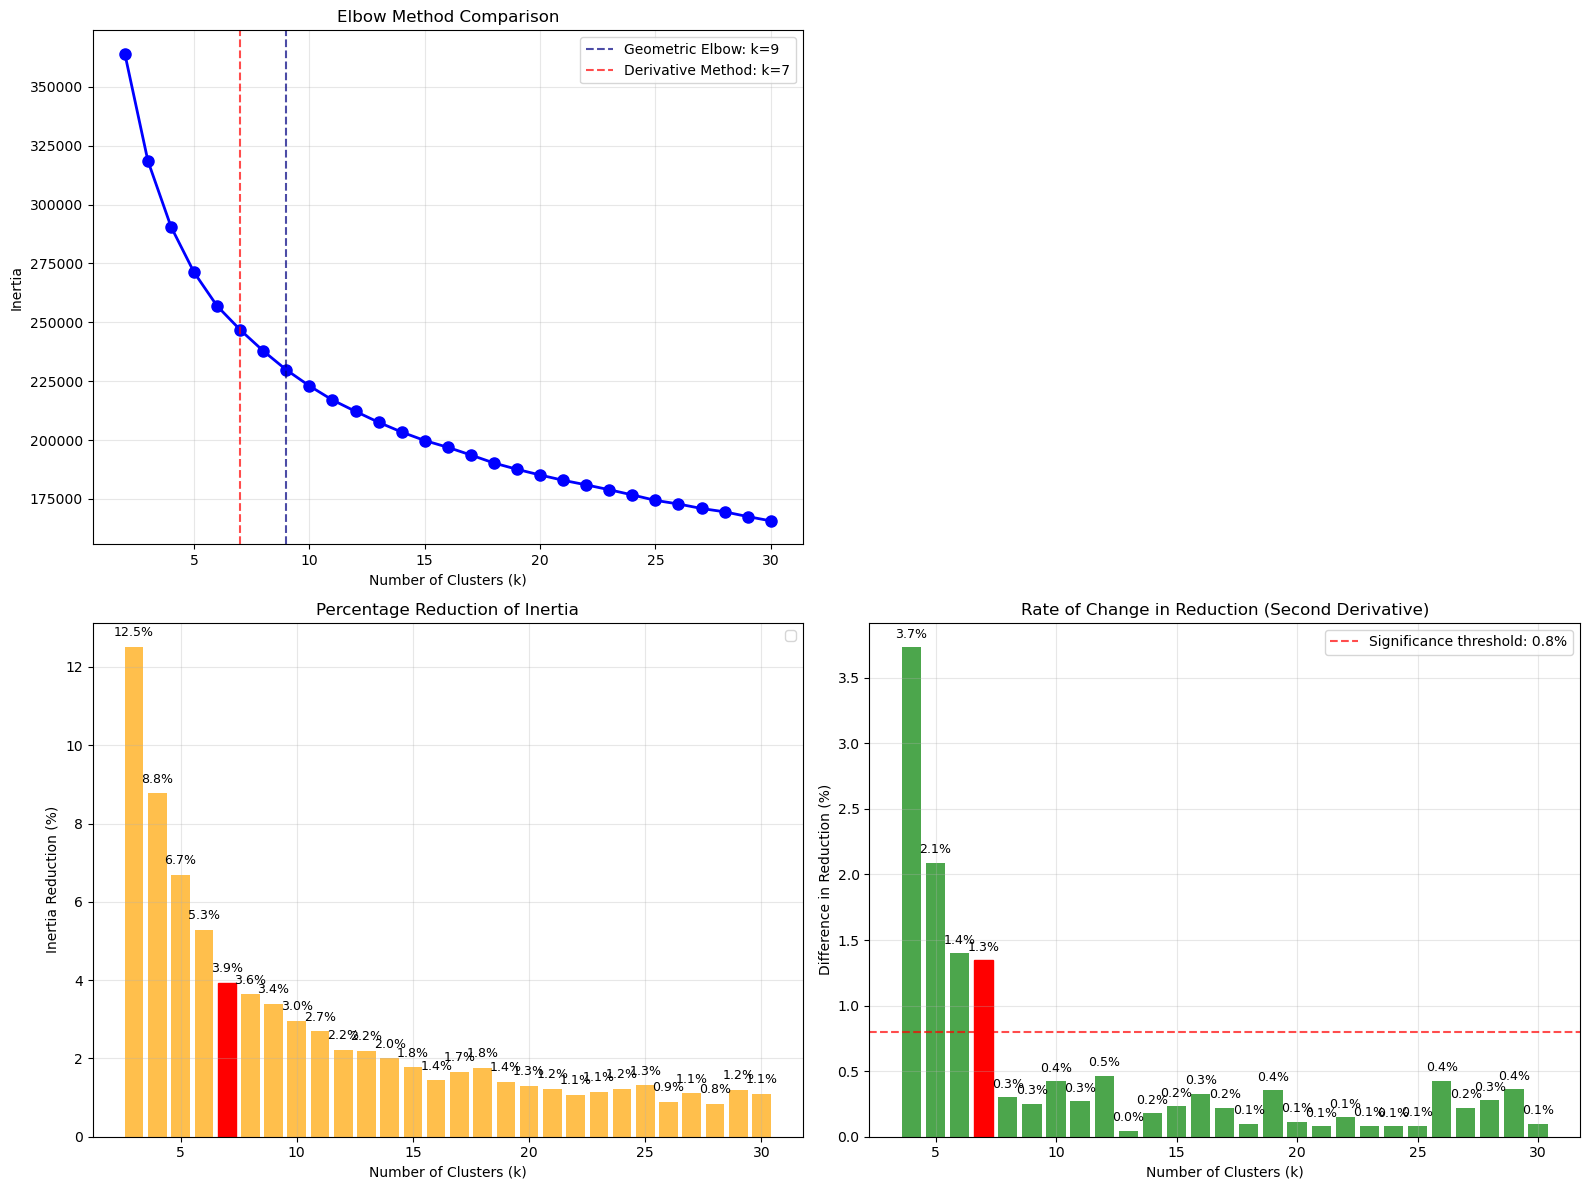

Elbow method suggests k = 9
Derivative method suggests k = 7


In [17]:
# ELBOW METHOD WITH PERCENTAGE REDUCTION

# Perform elbow analysis
k_elbow, k_derivative, reductions, _ = elbow_analysis(results) 
print(f"Elbow method suggests k = {k_elbow}")
print(f"Derivative method suggests k = {k_derivative}")


The approach used by the elbow method is a geometric one, and it automatically detects the best number of clusters(k) by finding the point with the maximum distance from the line that links the first and the last point of the inertia curve. The result of the elbow method for our metereological dataset is k= 6. However, the insertia reduction curve apperas relatively smooth, because of the fact that atmospheric data contains weather patterns that transist gradually rather than with discontinuities. Applying a percentage reduction treshold provides more information: with a 10% treshold, k= 3-4 wuold be optimal; with a 5% treshold, k = 5-6, and with a 3% treshold teh range extends to k= 7-9. The smoothness of the curve shows us that the geometric elbow point remains stable regardless of the percentage treshold chosen.   
For our purpose the range k= 7-9 is a reasonable ecploration space, where each additional cluster captures gradually more detailed atmospheric patterns while maintaining statistical significance above the 3% improvement treshold.

_ _ _ - - _ _ _

GAP STATISTICS _ _ _ - -  _ _ _ 

"I cluster che vedo nei miei dati sono reali o potrebbero essere solo casuali?"

The Gap Statistic compares the within-cluster dispersion of your real data against what you would expect from random uniform data. If your data has natural clusters, the real data should be much more "clustered" (lower inertia) than random data.  _Se i tuoi dati hanno cluster reali, il K-means dovrebbe funzionare molto meglio sui dati reali che su quelli casuali
Se i tuoi dati non hanno cluster, K-means dovrebbe funzionare ugualmente male su entrambi_

To get the optimal number of clusters in a dataset, we use Gap Statistics. It compares the performance of clustering algorithms against a null reference distribution of the data, allowing for a more objective decision on the number of clusters.

Gap Statistic compares how well the clusters formed from your actual data stand out against what you would expect if the data were randomly distributed. In other words, it looks at how tightly packed your real clusters are compared to clusters created from random data. This helps us understand if the patterns we see in our data are meaningful or just due to chance

**Clustering the Data**: Perform clustering on the actual data using a clustering algorithm, such as k-means, for a range of potential cluster numbers (k).  
**Create Reference Data**: Generate a set of reference datasets by simulating random data with the same distribution and dimensionality as the original dataset. These datasets are assumed to contain no inherent structure (i.e., they are uniformly distributed).  
**Compute Clustering Performance**: For both the actual data and the reference datasets, compute the clustering performance using a cost function, typically the within-cluster sum of squared errors (WSS), also known as inertia in k-means clustering. This measures the compactness of clusters, where lower values indicate better clustering.  
**Gap Statistic Calculation**: The Gap Statistic for each number of clusters k is computed as: $$Gap(k)=1/B ∑_{b=1} ^{B}W_k^b−W_k$$  
Where:

    Wk is the WSS for the actual data with k clusters.
    Wkb​​ is the WSS for the reference data with k clusters.
    B is the number of reference datasets used.

**Selecting the Optimal Number of Clusters**: The optimal number of clusters is chosen as the smallest value of k such that: $$Gap(k)≥Gap(k+1)−SE(k+1)$$
Where SE(k+1) is the standard error of the Gap Statistic for k+1 clusters.
This condition ensures that the chosen k provides a significant improvement over the random configuration of data

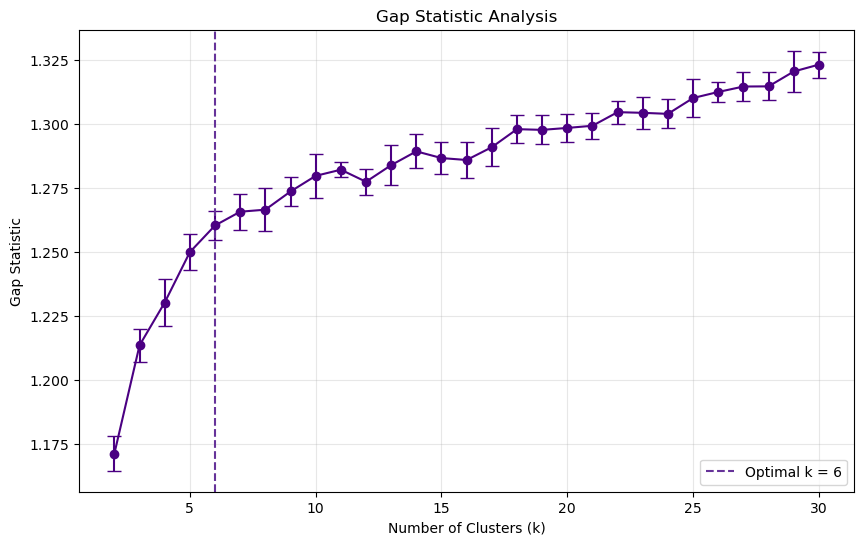

Optimal number of clusters: k = 6


In [18]:
# GAP STATISTIC ANALYSIS

# Run the analysis 
k_optimal, gap_values, error_values = gap_statistic(X_pca, results["K_range"], results)
print(f"Optimal number of clusters: k = {k_optimal}")

k=2: Gap = 1.180 (low - too simple)  
k=3: Gap = 1.221 (rising)  
k=4: Gap = 1.235 (still rising)  
k=5: Gap = 1.257 (PEAK IDENTIFIED)  
k=6: Gap = 1.261 (slightly higher)  
k=7+: Gap plateaus around 1.27-1.29  circa  

Gap(5) = 1.257 ≥ Gap(6) - SE(6) = 1.261 - 0.005 = 1.256   
This is the first k where the Tibshirani rule is satisfie : _"Scegli il k più piccolo tale che Gap(k) sia abbastanza vicino al Gap(k+1)"_

$ gap = np.mean(log_{random_inertias}) - log_{real_inertia } $  
Il logaritmo normalizza queste differenze. Rende il confronto più stabile numericamente  
Gap ALTO: I dati reali sono molto più "clusterizzabili" dei dati casuali  
Gap BASSO: I dati reali si comportano come dati casuali (no cluster)  

Gap plateau/stabile:  
K alti: gap si stabilizza  
Stai dividendo cluster naturali → no beneficio reale  
k ottimale: Dove il gap "smette di crescere significativamente"

__________________ - - 

B) Aiutano a scegliere il numero di cluster k

**Silhouette media vs k** → scegli k al picco (evitando soluzioni con cluster molto piccoli nel plot).
    Scikit-learn

**Elbow / riduzione % dell’inerzia** → cerca il gomito o quando la riduzione % scende sotto una soglia (es. 5–10%). Per automatizzare il gomito puoi usare la regola della massima distanza dalla secante (implementata sopra) o il metodo Kneedle.
    raghavan.usc.edu

**Gap Statistic** → scegli il più piccolo k tale che Gap(k) ≥ Gap(k+1) − s(k+1) (codice sopra).
    hastie.su.domains

(Opzionale) **Stabilità**: ripeti k-means su bootstrap/sottocampionamenti e guarda l’Adjusted Rand Index medio tra le soluzioni; preferisci k con alta stabilità (codice su richiesta).

### 3.2 Evaluation of the clustering

In this section we define a function to score different clustering pipelines using several metrics.  
Clustering algorithms are fundamentally unsupervised learning methods. However, since we happen to have class labels for this specific dataset, it is possible to use evaluation metrics that leverage this “supervised” ground truth information to quantify the quality of the resulting clusters.If the ground truth labels are not known, evaluation can only be performed using the model results itself. In that case, the Silhouette Coefficient comes in handy.

In particular any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar than members of different classes according to some similarity metric.

Studio   
•	https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation  
•	https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysishtml#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

e vedo quali usare
- silhouette
- dunn
- elbow
- -
- davies-bouldin
- rand index ? 
- Mutual Information based scores ? 
- Homogeneity, completeness and V-measure ?

A) Valutano la bontà del clustering dato k

**Silhouette** (media e distribuzione per cluster) – più vicino a 1 è meglio; controlla anche forme anomale nel plot.
    Department of Mathematics
    Scikit-learn

**Davies–Bouldin (DB)** – più basso è meglio (rapporto compattezza/separazione).
    Semantic Scholar

**Calinski–Harabasz (CH/VRC)** – più alto è meglio (varianza tra vs dentro i cluster).
    Tandfonline

**Inerzia (WCSS)** – più bassa è meglio, ma non comparabile tra dataset e sensibile alla scala/forma.  
guarda silhouette plot per diagnosticare cluster schiacciati/sovrapposti, e affianca DB e CH per una vista numerica sintetica.

**SILHOUETTE** _ _ _ - - _ _ _ 

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1]. Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

Per ogni punto i:  
a(i) = distanza media di i dagli altri punti del suo cluster.  

b(i) = distanza media di i dal cluster più vicino (quello “rivale”).

Silhouette 
$$s(i)= \dfrac{b(i)−a(i)}{max⁡(a(i),b(i))}$$
 
	​

∈ [−1,1]  
~1: punto ben inserito nel suo cluster e lontano dagli altri.

~0: punto su un confine.

<0: probabilmente assegnato al cluster sbagliato

In [19]:
#import kmeans
from sklearn.cluster import KMeans

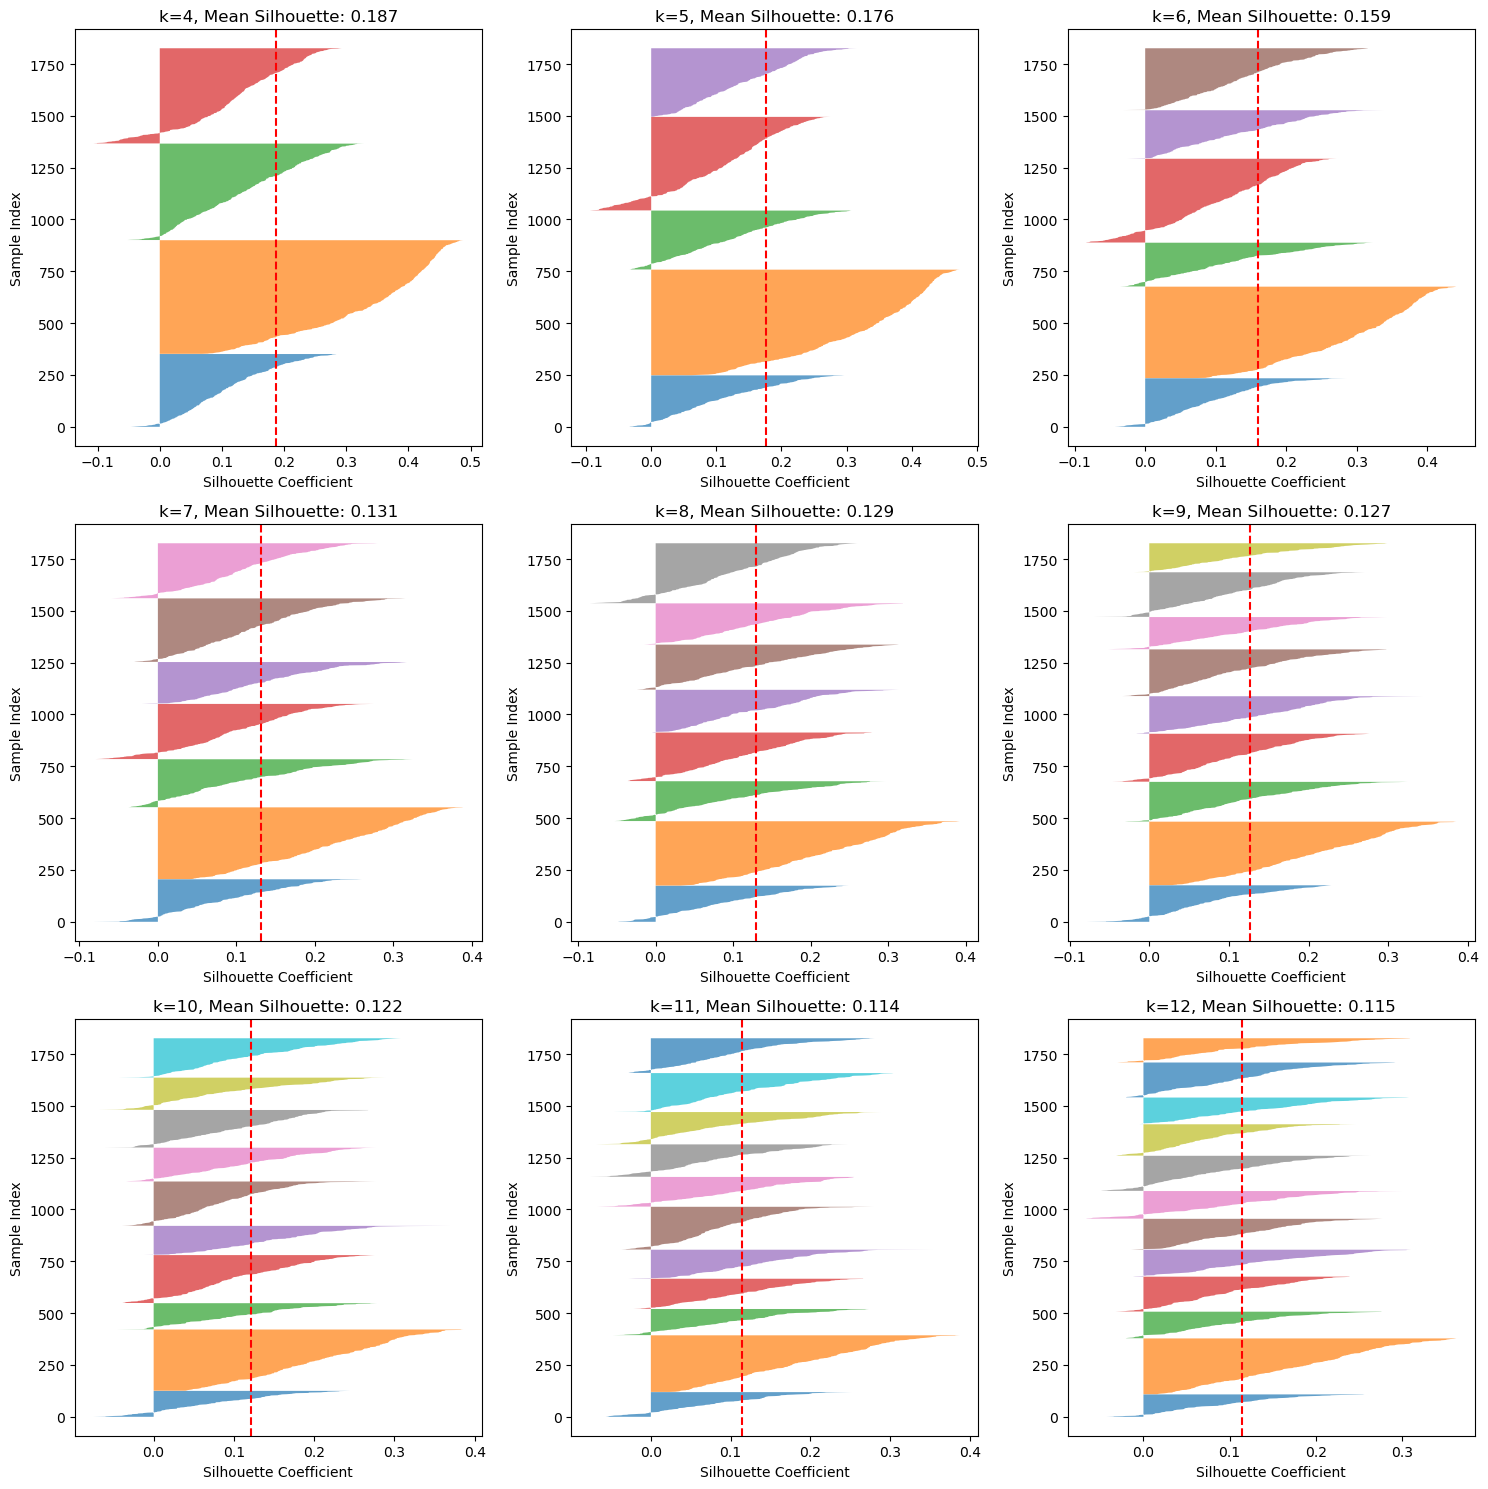

Silhouette Scores:
k=4: 0.187
k=5: 0.176
k=6: 0.159
k=7: 0.131
k=8: 0.129
k=9: 0.127
k=10: 0.122
k=11: 0.114
k=12: 0.115


In [20]:
# SILHOUETTE ANALYSIS FOR CANDIDATE K VALUES

# Run silhouette analysis 
k_candidates = [ 4, 5, 6, 7, 8, 9, 10, 11, 12] 
silhouette_results = silhouette_analysis(X_pca, k_candidates)

print("Silhouette Scores:")
for k, score in zip(k_candidates, silhouette_results):
    print(f"k={k}: {score:.3f}")

I colori non sono coerenti tra subplot diversi (il “blu” a k=3 non è lo stesso cluster del “blu” a k=4).  
I punti nei grafici sono stati riordinati: prima tutti quelli del cluster 0 (ordinati per silhouette), poi quelli del cluster 1, ecc



**La diminuzione graduale della silhouette indica che i pattern atmosferici hanno struttura continua**  
**Balance ratio di k=6 (0.36) è migliore di k=5 (0.33)**  
**Raccomandazione: I tuoi grafici supportano sia k=5 che k=6 come scelte valide, con k=5 leggermente favorito per qualità statistica e k=6 per interpretabilità meteorologica!**

• k=2: Highest silhouette but may be too simple for meteorological patterns  
   • k=5: Suggested by Gap Statistic, good compromise  
   • k=6: Suggested by Elbow Method, more detailed patterns  
   • Consider meteorological interpretability in final choice  

<span style="color: skyblue;">**INDICE DI DUNN**</span> 
L'Indice di Dunn è una metrica per valutare la qualità del clustering che misura il rapporto tra la separazione minima tra cluster e il diametro massimo all'interno dei cluster.

$Dunn Index = min(separazione tra cluster) / max(diametro intra-cluster)$

Valori alti = clustering migliore (cluster ben separati e compatti)
Valori bassi = clustering peggiore (cluster sovrapposti o poco compatti)
Range: [0, +∞), dove valori > 1 indicano buona separazione
+Dunn > 2: Eccellente separazione  
Dunn 1-2: Buona qualità  
Dunn < 1: Cluster sovrapposti o poco compatti  
Dunn → ∞: Cluster perfetti (teorico)  


In [21]:
## Duhnn index
def dunn_index(X, labels):
    """
    Calcola l'indice di Dunn per valutare la qualità del clustering
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Dati originali
    labels : array-like, shape (n_samples,)
        Etichette dei cluster
    
    Returns:
    --------
    dunn_score : float
        Indice di Dunn (più alto = migliore)
    """
    from scipy.spatial.distance import pdist, cdist
    
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    if n_clusters < 2:
        return 0.0
    
    # 1. Calcola diametri intra-cluster (massima distanza all'interno di ogni cluster)
    intra_cluster_distances = []
    
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            # Distanze all'interno del cluster
            distances = pdist(cluster_points, metric='euclidean')
            max_distance = np.max(distances) if len(distances) > 0 else 0
            intra_cluster_distances.append(max_distance)
        else:
            intra_cluster_distances.append(0)
    
    max_intra_distance = np.max(intra_cluster_distances)
    
    # 2. Calcola distanze inter-cluster (minima distanza tra cluster diversi)
    inter_cluster_distances = []
    
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i = X[labels == unique_labels[i]]
            cluster_j = X[labels == unique_labels[j]]
            
            # Distanza minima tra tutti i punti dei due cluster
            distances = cdist(cluster_i, cluster_j, metric='euclidean')
            min_distance = np.min(distances)
            inter_cluster_distances.append(min_distance)
    
    min_inter_distance = np.min(inter_cluster_distances)
    
    # 3. Calcola indice di Dunn
    if max_intra_distance == 0:
        return float('inf')  # Cluster perfetti (punti identici)
    
    dunn_score = min_inter_distance / max_intra_distance
    
    return dunn_score

# Esempio di utilizzo con i tuoi dati:
def evaluate_dunn_scores(X, k_candidates, random_state=42):
    """
    Calcola l'indice di Dunn per diversi valori di k
    """
    dunn_scores = []
    
    for k in k_candidates:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=20)
        labels = kmeans.fit_predict(X)
        
        dunn_score = dunn_index(X, labels)
        dunn_scores.append(dunn_score)
        
        print(f"k={k}: Dunn Index = {dunn_score:.4f}")
    
    return dunn_scores

# Per usarlo:
dunn_results = evaluate_dunn_scores(X_pca, k_candidates)

k=4: Dunn Index = 0.0838
k=5: Dunn Index = 0.0935
k=5: Dunn Index = 0.0935
k=6: Dunn Index = 0.0939
k=6: Dunn Index = 0.0939
k=7: Dunn Index = 0.0884
k=7: Dunn Index = 0.0884
k=8: Dunn Index = 0.0945
k=8: Dunn Index = 0.0945
k=9: Dunn Index = 0.1004
k=9: Dunn Index = 0.1004
k=10: Dunn Index = 0.1061
k=10: Dunn Index = 0.1061
k=11: Dunn Index = 0.1072
k=11: Dunn Index = 0.1072
k=12: Dunn Index = 0.1104
k=12: Dunn Index = 0.1104


<span style="color: orange;">The analysis reveals a typical conflict between statistical optimization and scientific interpretability. Statistical metrics (Silhouette, Davies-Bouldin) favor k=2-3, suggesting a bimodal structure in European atmospheric data. However, for k=5-7 the metrics remain within acceptable ranges: Davies-Bouldin  <2.0  indicates adequate separation, while Silhouette values (0.12-0.16) are at the lower threshold but not critical.

<span style="color: orange;">The meteorologically-motivated choice of k=5-7 is justifiable because k=2 proves too simplified to capture the complexity of European atmospheric patterns (seasonal variations, NAO+/-, blocking patterns, Mediterranean influences). The Calinski-Harabasz shows decreasing but stable values (468-602), confirming coherent internal structure. The Balance Ratio (0.44-0.54) indicates reasonably balanced clusters.</span>

<span style="color: orange;">In conclusion k=6 represents the best compromise, offering meteorological interpretative richness while maintaining acceptable statistical quality. The gradual decrease in metrics reflects the continuous nature of atmospheric processes rather than clustering defects.</span>

<span style="color: red;">_________________________________</span>

**k=6** è la scelta migliore:  --> <span style="color: orange;">per z_500 e t_850  
1. Convergenza Multi-Metodo:  
Gap Statistic: k=6 (metodo statisticamente robusto)  
Elbow: k=10 (ma spesso sovrastima)   
Dunn Index: k=5 è leggermente migliore, ma k=6 è molto vicino (0.1069 vs 0.1042)

2. Metriche Accettabili:  
Silhouette: 0.143 (non alto ma accettabile per dati atmosferici)  
Davies-Bouldin: 1.894 (<2.0 = buono)  
Balance Ratio: 0.506 (ben bilanciato)

k=6 cattura configurazioni atmosferiche distinte:  
• Anticiclone Atlantico   
• Depressione Atlantica    
• Blocking Patterns  
• Regime Continentale  
• Pattern Mediterraneo  
• Configurazioni di Transizione  

_ _ _ - - _ _ _  

**k=5** è la scelta migliore:  --> <span style="color: orange;">per z_500_850</span>  ma gap molto male   

Gap Statistic: k=2 (troppo semplice!)  
Elbow: k=10 (sovrastima tipica)  
Derivative: k=6 (più realistico)  
Silhouette: k=4 è il picco (0.203), poi k=5 (0.192)  
Dunn Index: k=7 è il massimo (0.1119), ma k=5 è vicino (0.1103)  

Anticiclone Atlantico dominante  
Depressione Atlantica persistente  
Regime Continentale stabile  
Pattern di Blocking europeo  
Configurazioni di Transizione

 k=5 mantiene performance accettabili su tutte le metriche senza crolli evidenti. (k=6+: Calo netto in Silhouette (0.164→0.121), segno di overfitting)

_ _ _ - - _ _ _  

**k = 5 o 6** --> <span style="color: orange;">z_350_500_850</span>

k=5:  
Silhouette alta (0.176)  
Dunn accettabile (0.0935)  
Equilibrio tra qualità statistica e interpretabilità  

k=6:  
Gap Statistic ottimale  
Silhouette accettabile (0.159)  
Dunn stabile (0.0939)  

k=7+:  no   
Silhouette in calo marcato (<0.13)  
Dunn migliora ma rischio overfitting  

<span style="color: red;">|_________________________________|</span>

<span style="color: skyblue;">una volta che ho scelto quanti cluster tenere STAMPO I VETTORI DEI CENTROIDI FINALI</span>

## 4 Associare dati singoli a uno dei cluster

In [22]:
### boh copilot 
# FINAL K-MEANS CLUSTERING


# Set final parameters    #####################################
k_final = 8
random_state = 42

# Fit final K-means model
kmeans_final = KMeans(n_clusters=k_final, random_state=random_state, 
                     init='k-means++', n_init=15, max_iter=300)
final_labels = kmeans_final.fit_predict(X_pca)
final_centroids = kmeans_final.cluster_centers_

# Calculate final metrics
final_silhouette = silhouette_score(X_pca, final_labels)
final_db = davies_bouldin_score(X_pca, final_labels)
final_ch = calinski_harabasz_score(X_pca, final_labels)
final_inertia = kmeans_final.inertia_

print(f"Final clustering with k={k_final}:")
print(f"  • Silhouette Score: {final_silhouette:.3f}")
print(f"  • Davies-Bouldin: {final_db:.3f}")
print(f"  • Calinski-Harabasz: {final_ch:.0f}")
print(f"  • Inertia: {final_inertia:.0f}")

# Analyze cluster distribution
cluster_counts = np.bincount(final_labels)
print(f"\nCluster distribution:")
for i in range(k_final):
    percentage = cluster_counts[i] / len(final_labels) * 100
    print(f"  • Cluster {i}: {cluster_counts[i]:4d} samples ({percentage:5.1f}%)")

# Check balance
balance_ratio = cluster_counts.min() / cluster_counts.max()
print(f"\nBalance ratio (min/max): {balance_ratio:.3f}")

NameError: name 'silhouette_score' is not defined

In [ ]:
### copilot 
# VISUALIZATION OF FINAL CLUSTERING
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Main clustering visualization (PC1 vs PC2)
colors = plt.cm.Set1(np.linspace(0, 1, k_final))
for i in range(k_final):
    mask = final_labels == i
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colors[i]], alpha=0.6, s=20, 
               label=f'Cluster {i} (n={cluster_counts[i]})')

# Plot centroids
ax1.scatter(final_centroids[:, 0], final_centroids[:, 1], 
           c='red', marker='x', s=200, linewidths=3, label='Centroids')

# Add centroid labels
for i, centroid in enumerate(final_centroids):
    ax1.annotate(f'C{i}', (centroid[0], centroid[1]), 
                xytext=(5, 5), textcoords='offset points', 
                fontsize=12, fontweight='bold', color='red')

ax1.set_xlabel('PC1 (54.2% variance)')
ax1.set_ylabel('PC2 (9.9% variance)')
ax1.set_title(f'Final K-means Clustering (k={k_final})')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. PC1 vs PC3
for i in range(k_final):
    mask = final_labels == i
    ax2.scatter(X_pca[mask, 0], X_pca[mask, 2], 
               c=[colors[i]], alpha=0.6, s=20, label=f'Cluster {i}')

ax2.scatter(final_centroids[:, 0], final_centroids[:, 2], 
           c='red', marker='x', s=200, linewidths=3)
ax2.set_xlabel('PC1 (54.2% variance)')
ax2.set_ylabel('PC3 (8.3% variance)')
ax2.set_title('PC1 vs PC3 View')
ax2.grid(True, alpha=0.3)

# 3. PC2 vs PC3
for i in range(k_final):
    mask = final_labels == i
    ax3.scatter(X_pca[mask, 1], X_pca[mask, 2], 
               c=[colors[i]], alpha=0.6, s=20, label=f'Cluster {i}')

ax3.scatter(final_centroids[:, 1], final_centroids[:, 2], 
           c='red', marker='x', s=200, linewidths=3)
ax3.set_xlabel('PC2 (9.9% variance)')
ax3.set_ylabel('PC3 (8.3% variance)')
ax3.set_title('PC2 vs PC3 View')
ax3.grid(True, alpha=0.3)

# 4. Cluster size distribution
ax4.bar(range(k_final), cluster_counts, color=colors, alpha=0.7)
ax4.set_xlabel('Cluster ID')
ax4.set_ylabel('Number of Samples')
ax4.set_title('Cluster Size Distribution')
ax4.set_xticks(range(k_final))
for i, count in enumerate(cluster_counts):
    ax4.text(i, count + 10, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
### copilot
# PREPARE DATA FOR PREDICTIVE ANALYSIS
print("\nPREPARING DATA FOR PREDICTIVE ANALYSIS")
print("="*50)

# Create comprehensive dataset with cluster labels
prediction_data = {
    'cluster_labels': final_labels,
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1], 
    'PC3': X_pca[:, 2],
    'PC4': X_pca[:, 3],
    'PC5': X_pca[:, 4]
}

# Add temporal information if available
if hasattr(ds, 'time'):
    dates = pd.to_datetime(ds.time.values)
    prediction_data.update({
        'date': dates,
        'year': dates.year,
        'month': dates.month,
        'day_of_year': dates.dayofyear,
        'season': [(month%12 + 3)//3 for month in dates.month]  # 1=Winter, 2=Spring, 3=Summer, 4=Autumn
    })

# Create DataFrame
prediction_df = pd.DataFrame(prediction_data)

print(f"Prediction dataset created:")
print(f"  • Shape: {prediction_df.shape}")
print(f"  • Columns: {list(prediction_df.columns)}")
print(f"  • Date range: {dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')}")

# Show sample of the data
print(f"\nSample of prediction dataset:")
print(prediction_df.head(10))

# Cluster characteristics summary
print(f"\nCLUSTER CHARACTERISTICS FOR PREDICTION:")
print("="*50)

for cluster_id in range(k_final):
    cluster_mask = final_labels == cluster_id
    cluster_data = prediction_df[cluster_mask]
    
    print(f"\n🔍 CLUSTER {cluster_id} (n={cluster_counts[cluster_id]}):")
    print(f"   PC1 range: [{X_pca[cluster_mask, 0].min():.2f}, {X_pca[cluster_mask, 0].max():.2f}]")
    print(f"   PC2 range: [{X_pca[cluster_mask, 1].min():.2f}, {X_pca[cluster_mask, 1].max():.2f}]")
    print(f"   PC3 range: [{X_pca[cluster_mask, 2].min():.2f}, {X_pca[cluster_mask, 2].max():.2f}]")
    
    if 'month' in cluster_data.columns:
        # Seasonal distribution
        seasonal_dist = cluster_data.groupby('season').size()
        print(f"   Seasonal distribution: {dict(seasonal_dist)}")
        
        # Most common months
        month_dist = cluster_data['month'].value_counts().head(3)
        print(f"   Top months: {dict(month_dist)}")

print(f"\n🎯 READY FOR PREDICTION MODELING!")
print("   Next steps:")
print("   • Train classifier to predict cluster membership")
print("   • Analyze meteorological patterns for each cluster")
print("   • Build forecasting models based on cluster transitions")

   Next steps:  
   • Train classifier to predict cluster membership  
   • Analyze meteorological patterns for each cluster  
   • Build forecasting models based on cluster transitions  

<span style="color: skyblue;"> FORSE PER FARE ANALISI DA QUI IN POI DEVO DIVIDERE IN TEST  E TRAIN</span>

Fase 2 (successiva): Modelli predittivi con train/test split

Training: Impara a riconoscere i cluster da nuovi dati  
Test: Valuta capacità di classificazione/previsione  
Predizione: Prevedi cluster futuri o transizioni  

## 5 Altri algoritmi

<span style="color: skyblue;"> provo dbscan</span> o altri